In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from A3C import A3C
import os
from collections import defaultdict
from run_session import run_session
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import f_oneway
import sklearn.linear_model, sklearn.neural_network

load = True
device = 0
np.random.seed(12345)
torch.random.manual_seed(12345)
np.set_printoptions(suppress=True, precision=4)

## Maybe add in pseudo-random left/right later?

In [2]:
class lever():
    def __init__(self):
        super().__init__()
        self.num_presses = 2000 # perhaps this number needs to be changed
        self.mode = "PR"
        self.current_presses = 0
        self.switch_time = [np.random.randint(466, 866), np.random.randint(1132, 1532)] # the presses after which backswitch is turned on
        self.resets = [] # the presses at which reset is done
        self.parameters = []
        self.backswitch = False
        self.reset()
        
    def pull(self, choice):
        if self.current_presses in self.switch_time:
            self.backswitch = True
        if self.progress == 0:
            if self.backswitch:
                self.reset()
                self.backswitch = False
        self.current_presses += 1
        modes = ["PR", "FR"]
        if modes[choice] == self.mode:
            self.progress += 1
        else: # incomplete
            self.progress = 0
            self.mode = modes[choice]
        if self.progress > self.limits[modes[choice]]:
            print("error: progress shouldn't be greater than limit")
        if self.progress ==  self.limits[modes[choice]]: # complete
            if modes[choice] == "PR":
                self.limits["PR"] += 1
            self.progress = 0
            temp = self.rewards[modes[choice]] # reward could be reset
            return temp
        return 0
    
    def reset(self):
        self.resets.append(self.current_presses)
        FR_limit = [6, 12][np.random.choice(2)]
        PR_reward = [2, 5][np.random.choice(2)]
        self.limits = {"PR":2, "FR":FR_limit}
        self.rewards = {"PR":PR_reward, "FR":1}
        self.progress = 0
        self.parameters.append((FR_limit, PR_reward))
        
def count_trials(actions, rewards, activ_hist): # activ_hist can be swapped out by value
    """
    action tags:
        0: PR
        1: FR
    trial tags:
        0: PR
        1: FR
        2: incomplete
    Returns:
        trials: actions grouped by trial
        trial_tags: type of trials
        trial_activ: activation grouped by trial
    """
    trials = []
    trial_tags = []
    trial_activ = []
    current_trial = []
    current_trial_activ = []
    for action, reward, activ in zip(actions, rewards, activ_hist):
        if current_trial == []: # start new trial
            current_trial.append(action)
            current_trial_activ.append(activ)
        else:
            if current_trial[-1] != action: # previous trial incomplete, initialize new trial
                current_trial.append(action)
                current_trial_activ.append(activ)
                trials.append(current_trial)
                trial_activ.append(current_trial_activ)
                trial_tags.append(2)
                current_trial = []
                current_trial_activ = []
            elif reward > 0: # if current_trial[-1] == action and reward > 0, complete trial
                current_trial.append(action)
                current_trial_activ.append(activ)
                trials.append(current_trial)
                trial_activ.append(current_trial_activ)
                trial_tags.append(action)
                current_trial = []
                current_trial_activ = []
            else:
                current_trial.append(action) # if current_trial[-1] == action and reward = 0, continue trial
                current_trial_activ.append(activ)
    return trials, trial_tags, trial_activ

agent = A3C().cuda(device)
optimizer = torch.optim.RMSprop(agent.parameters(), 0.0007)

In [3]:
# try parallelism
# train or load
if load and os.path.exists('models/PRvsFR.pth'):
    agent.load_state_dict(torch.load('models/PRvsFR.pth'))
else:
    for session_num in range(0, 20000):
        experiment = lever()
        run_session(experiment, agent, optimizer, session_num, be=0.075)
    torch.save(agent.state_dict(), "models/PRvsFR.pth")

session: 0 reward: 0.1615


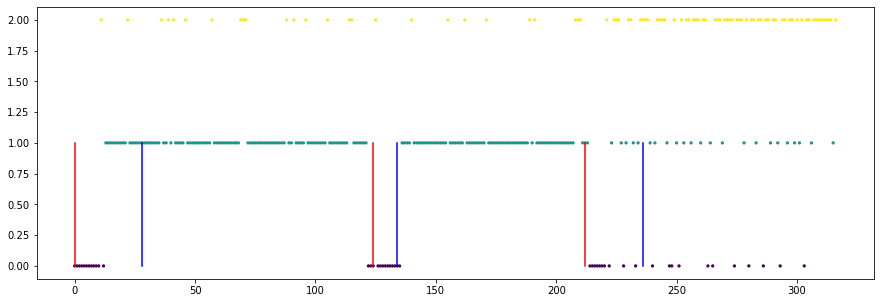

In [4]:
optimal_switch = {(6, 2):10, (12, 2):22, (6, 5):28, (12, 5):58} #a*b-2
# visualize
experiment = lever()
actions, rewards, value_preds = run_session(experiment, agent, optimizer, 0, train = False)
resets = experiment.resets
params = experiment.parameters
trials, trial_tags, trial_activ = count_trials(actions, rewards, agent.activ_hist)
plt.figure(figsize = (15, 5))
scatter = plt.scatter(np.arange(len(trial_tags)), trial_tags, s = 5, c = trial_tags)
for reset, param in zip(resets, params):
    trial_to_presses = np.cumsum([len(trial) for trial in trials])
    reset_trial = np.searchsorted(trial_to_presses, reset)
    plt.plot([reset_trial, reset_trial], [0, 1], color='red')
    for trial_num in range(reset_trial, len(trial_tags)):
        if trial_tags[trial_num] == 0:
            optimal_switch_trial_num = trial_num + optimal_switch[param]
            break
    plt.plot([optimal_switch_trial_num, optimal_switch_trial_num], [0, 1], color='blue')

session: 0 reward: 0.1885


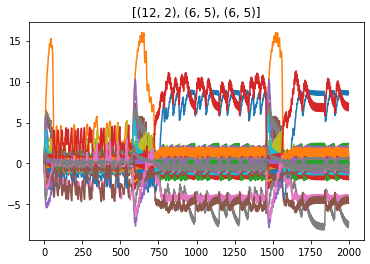

session: 1 reward: 0.213


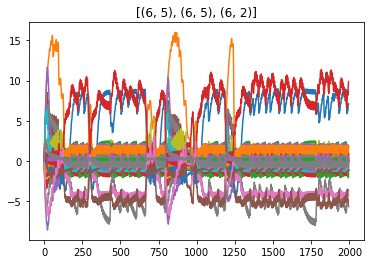

session: 2 reward: 0.154


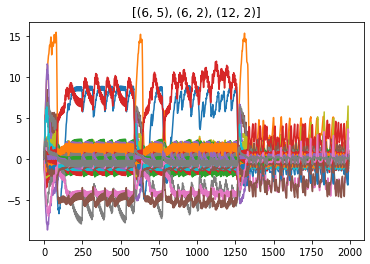

session: 3 reward: 0.173


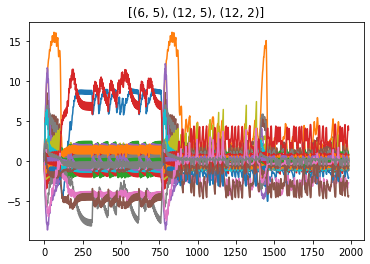

session: 4 reward: 0.15


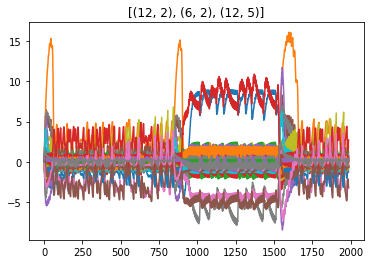

session: 5 reward: 0.1885


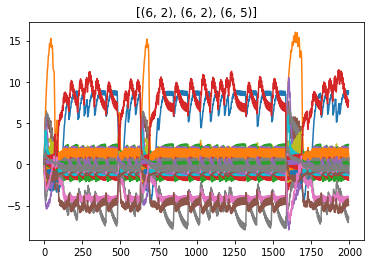

session: 6 reward: 0.163


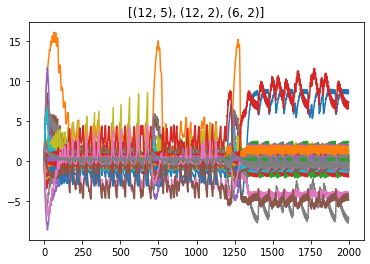

session: 7 reward: 0.199


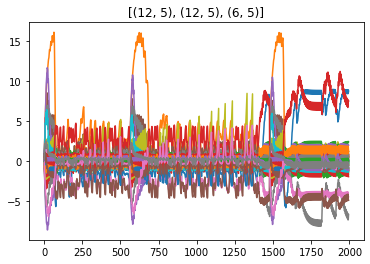

session: 8 reward: 0.138


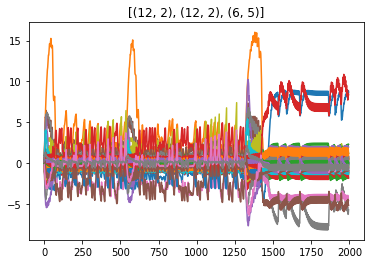

session: 9 reward: 0.2235


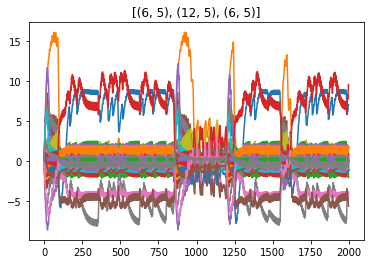

session: 10 reward: 0.194


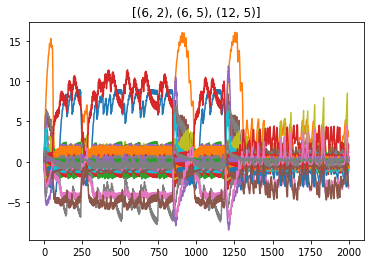

session: 11 reward: 0.2305


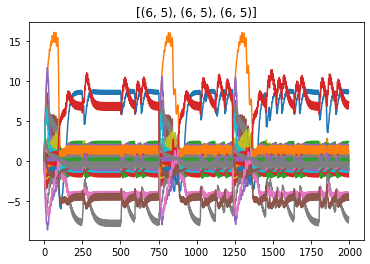

session: 12 reward: 0.1845


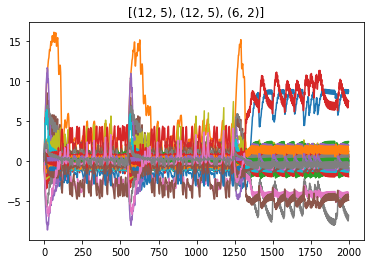

session: 13 reward: 0.2095


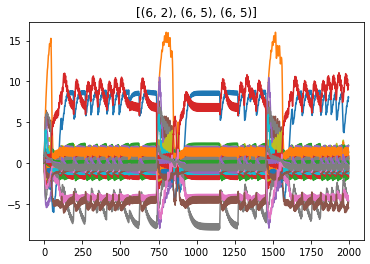

session: 14 reward: 0.2025


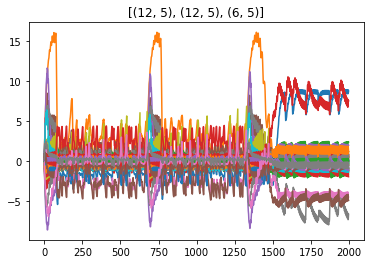

session: 15 reward: 0.178


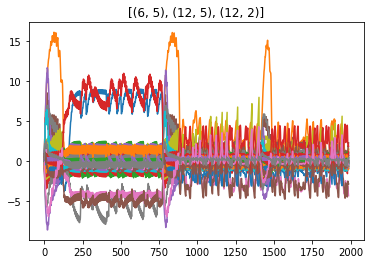

session: 16 reward: 0.2155


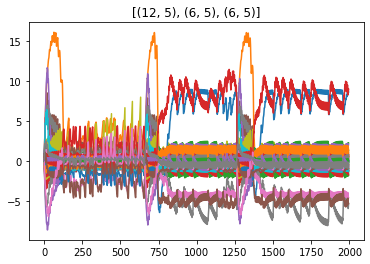

session: 17 reward: 0.193


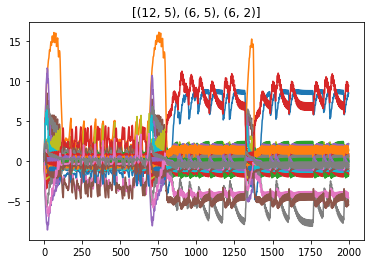

session: 18 reward: 0.2


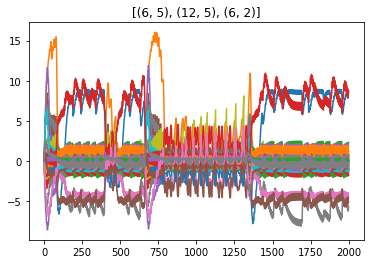

session: 19 reward: 0.1485


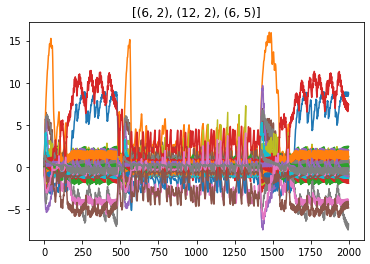

session: 20 reward: 0.194


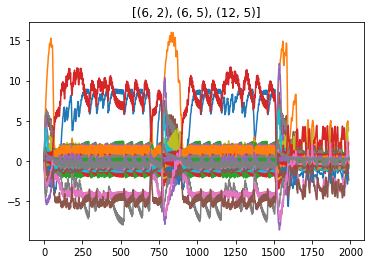

session: 21 reward: 0.1955


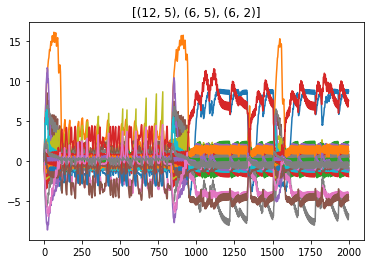

session: 22 reward: 0.1535


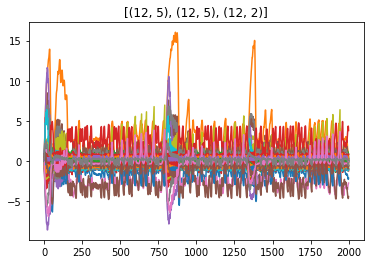

session: 23 reward: 0.176


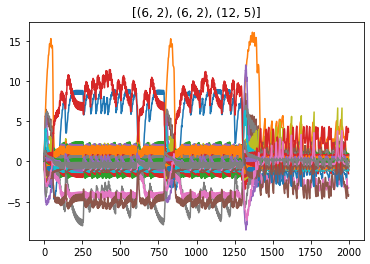

session: 24 reward: 0.09


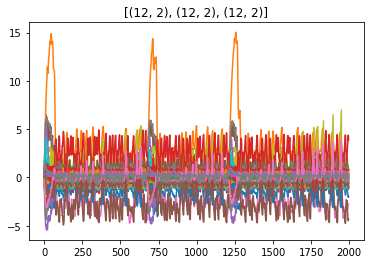

session: 25 reward: 0.2195


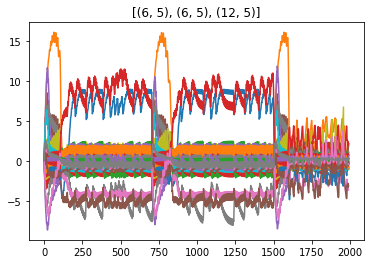

session: 26 reward: 0.184


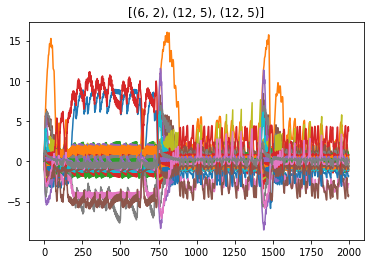

session: 27 reward: 0.104


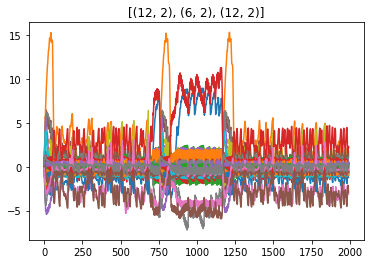

session: 28 reward: 0.1435


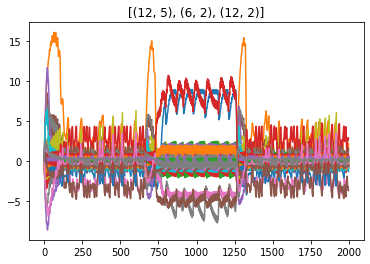

session: 29 reward: 0.2225


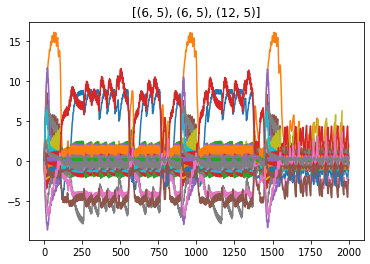

session: 30 reward: 0.1765


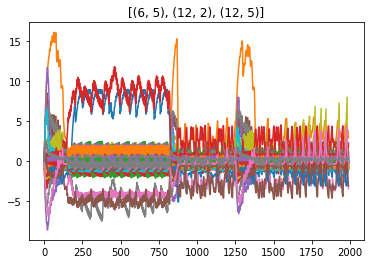

session: 31 reward: 0.191


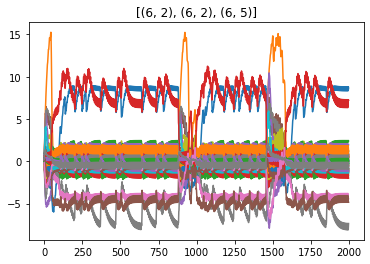

session: 32 reward: 0.174


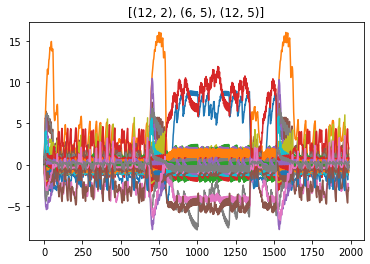

session: 33 reward: 0.1455


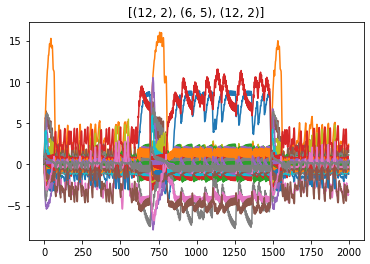

session: 34 reward: 0.2085


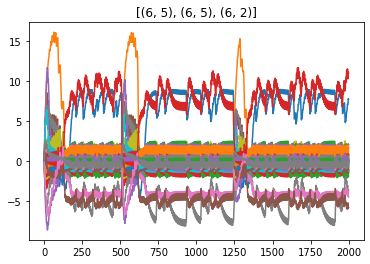

session: 35 reward: 0.1415


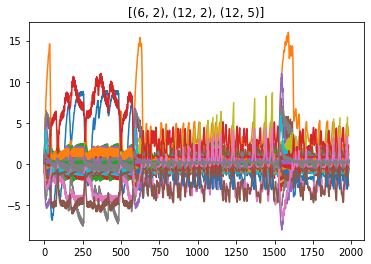

session: 36 reward: 0.1605


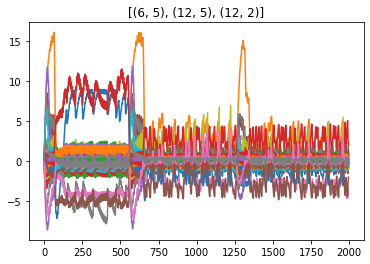

session: 37 reward: 0.158


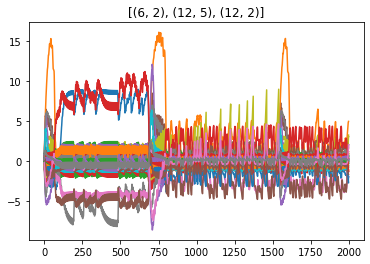

session: 38 reward: 0.1255


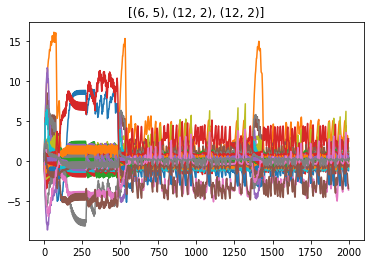

session: 39 reward: 0.167


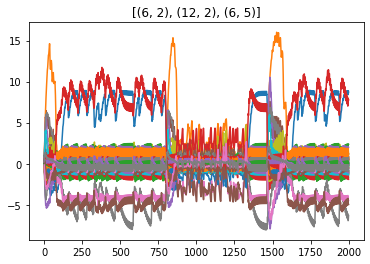

session: 40 reward: 0.2145


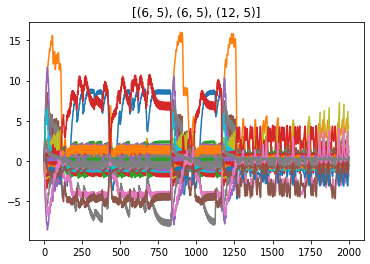

session: 41 reward: 0.1795


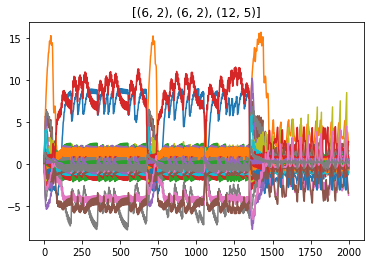

session: 42 reward: 0.2045


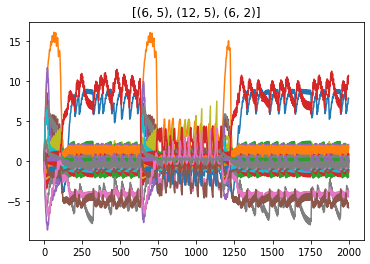

session: 43 reward: 0.1675


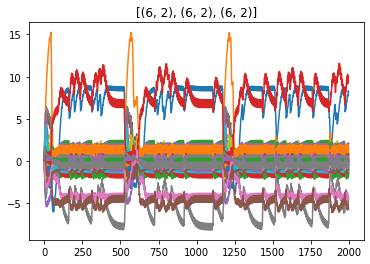

session: 44 reward: 0.1505


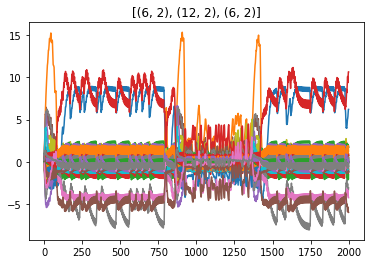

session: 45 reward: 0.09


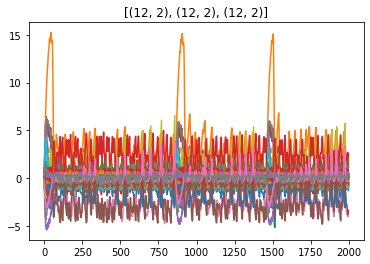

session: 46 reward: 0.16


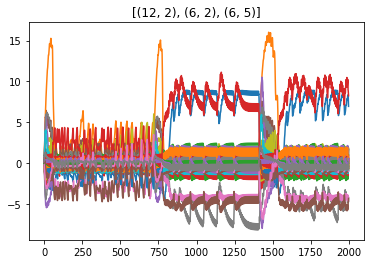

session: 47 reward: 0.183


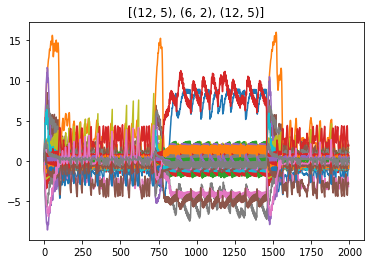

session: 48 reward: 0.1525


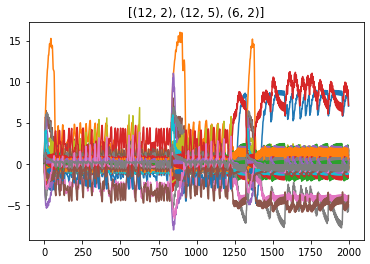

session: 49 reward: 0.2095


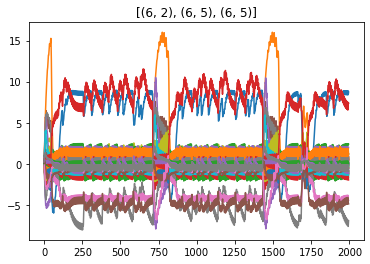

session: 50 reward: 0.136


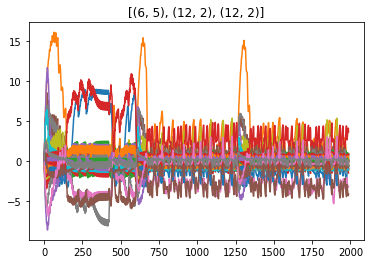

session: 51 reward: 0.1275


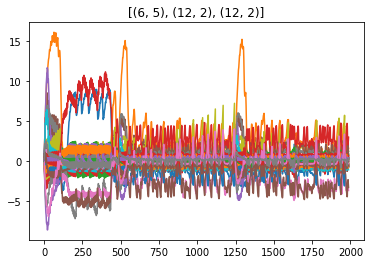

session: 52 reward: 0.2065


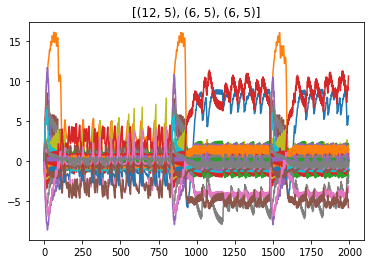

session: 53 reward: 0.1525


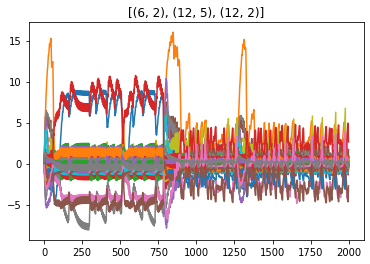

session: 54 reward: 0.1445


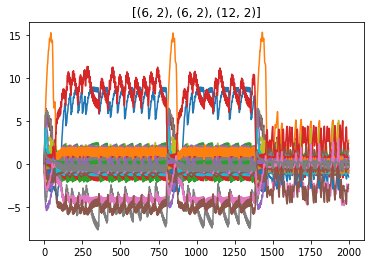

session: 55 reward: 0.207


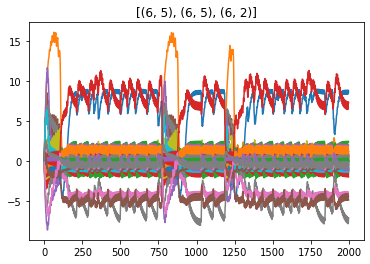

session: 56 reward: 0.1695


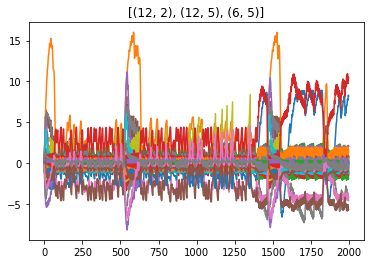

session: 57 reward: 0.1575


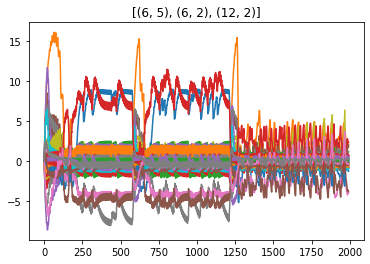

session: 58 reward: 0.1495


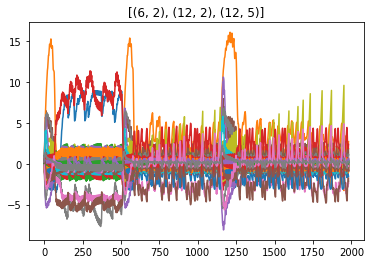

session: 59 reward: 0.203


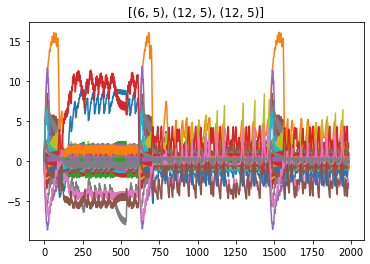

session: 60 reward: 0.136


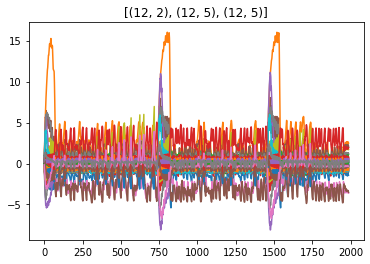

session: 61 reward: 0.1805


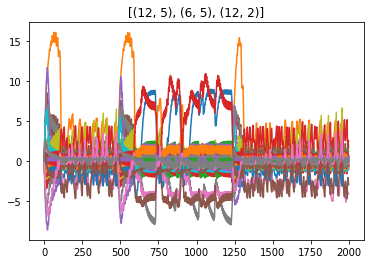

session: 62 reward: 0.1675


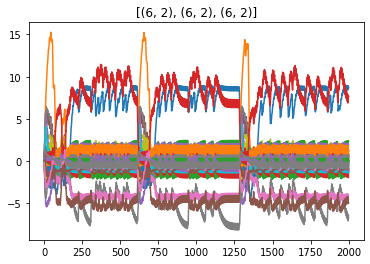

session: 63 reward: 0.115


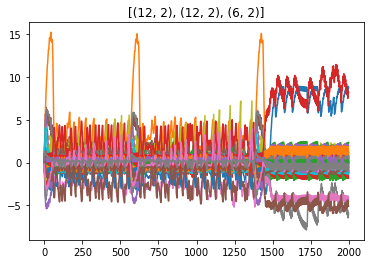

session: 64 reward: 0.179


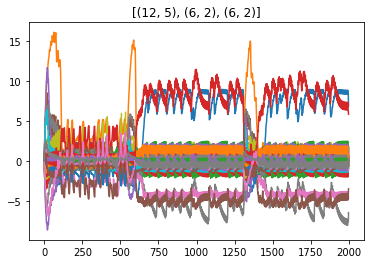

session: 65 reward: 0.197


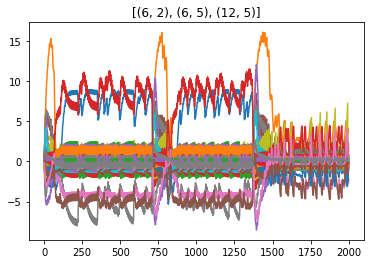

session: 66 reward: 0.18


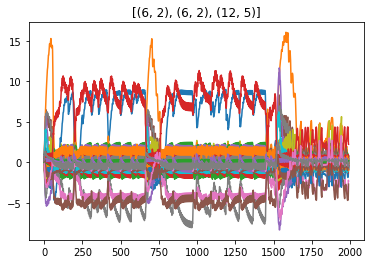

session: 67 reward: 0.118


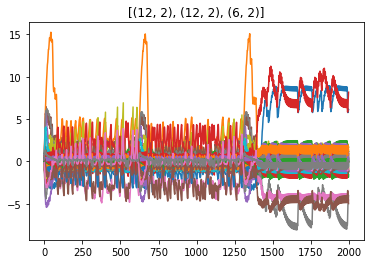

session: 68 reward: 0.163


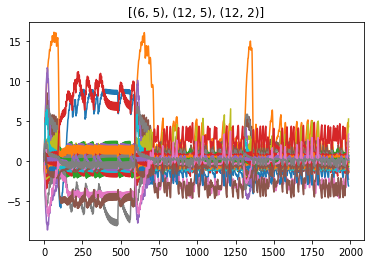

session: 69 reward: 0.146


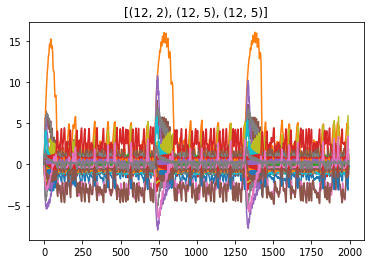

session: 70 reward: 0.187


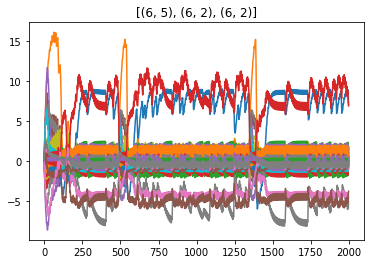

session: 71 reward: 0.1235


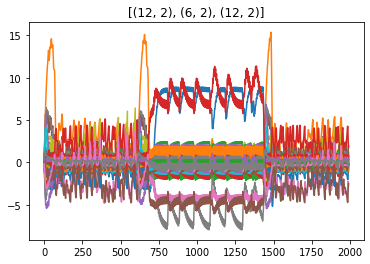

session: 72 reward: 0.131


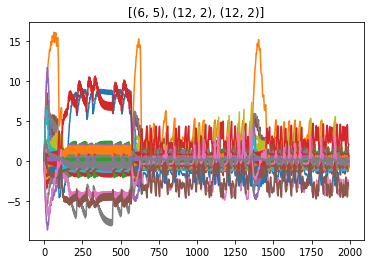

session: 73 reward: 0.2115


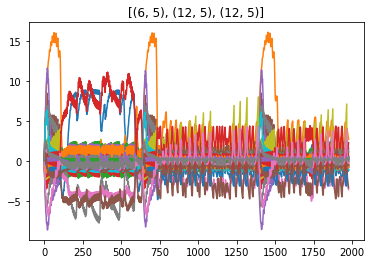

session: 74 reward: 0.1555


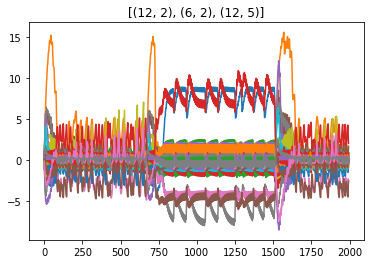

session: 75 reward: 0.2155


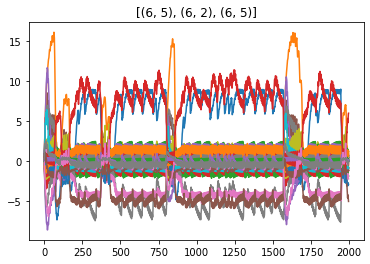

session: 76 reward: 0.1525


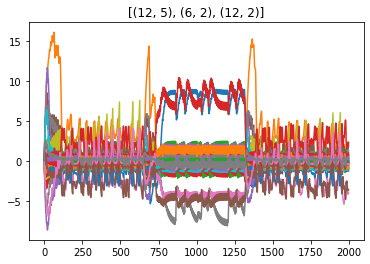

session: 77 reward: 0.165


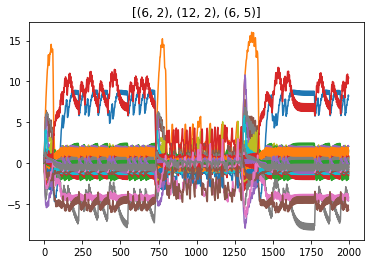

session: 78 reward: 0.2045


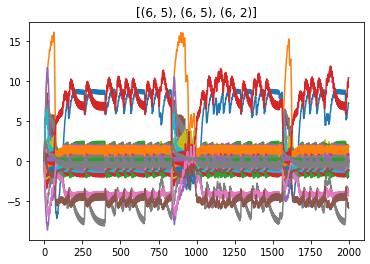

session: 79 reward: 0.205


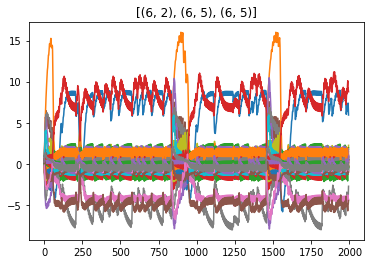

session: 80 reward: 0.1475


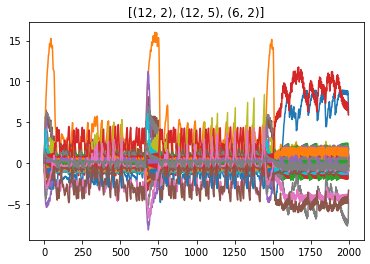

session: 81 reward: 0.1435


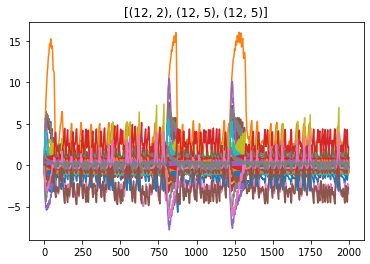

session: 82 reward: 0.1705


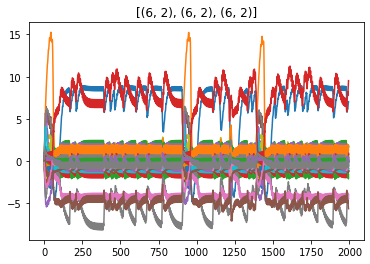

session: 83 reward: 0.1535


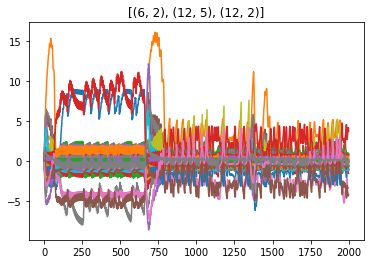

session: 84 reward: 0.1185


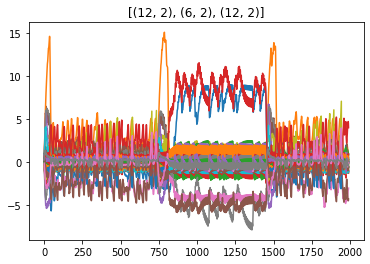

session: 85 reward: 0.164


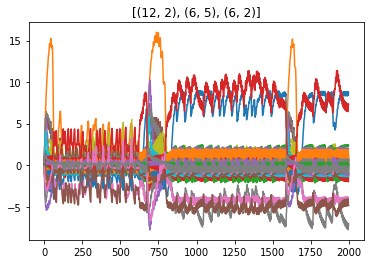

session: 86 reward: 0.1355


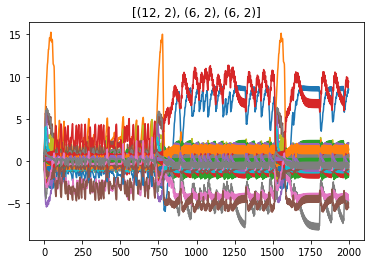

session: 87 reward: 0.2075


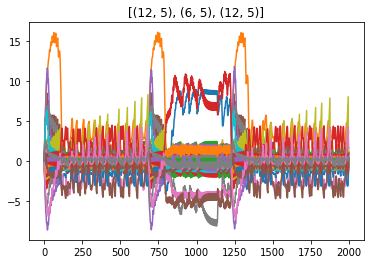

session: 88 reward: 0.2175


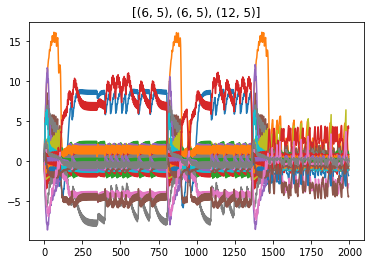

session: 89 reward: 0.167


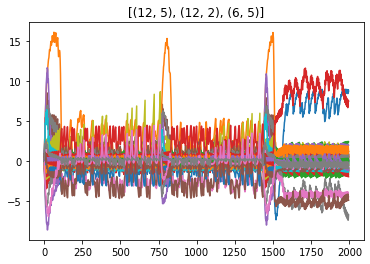

session: 90 reward: 0.212


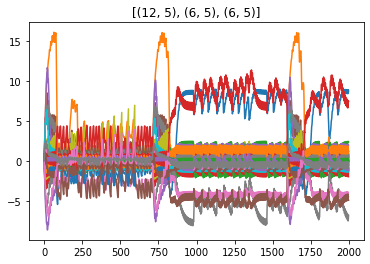

session: 91 reward: 0.176


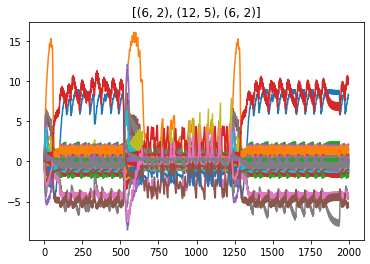

session: 92 reward: 0.1955


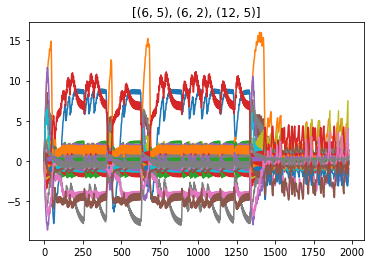

session: 93 reward: 0.143


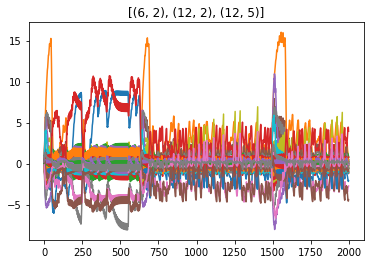

session: 94 reward: 0.144


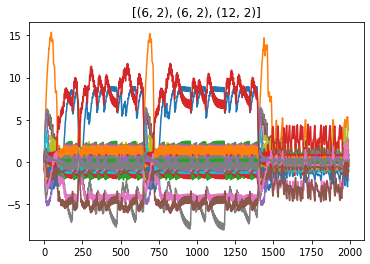

session: 95 reward: 0.1625


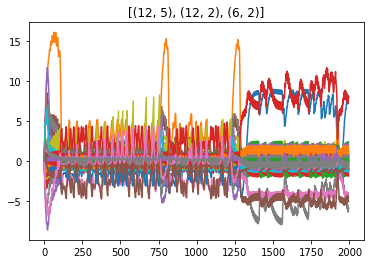

session: 96 reward: 0.167


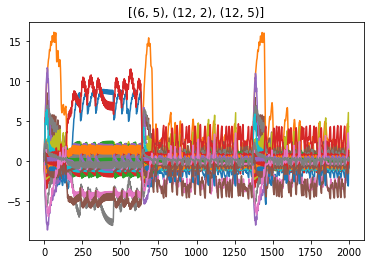

session: 97 reward: 0.206


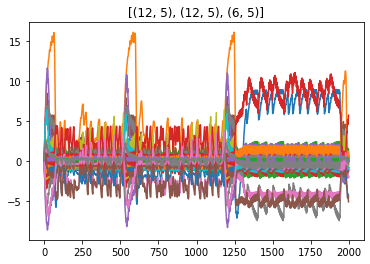

session: 98 reward: 0.1975


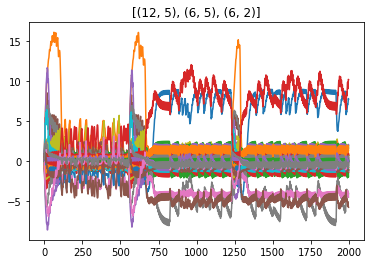

session: 99 reward: 0.1195


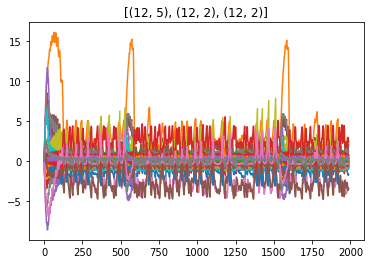

In [31]:
# X: activations list of [48] vectors
# Y: parameters
# tags: trial selection
# num_pressed_test: number pressed
X = []
Y = []
tags = []
num_pressed = []
param_settings_idx = {(6, 2):0, (12, 2):1, (6, 5):2, (12, 5):3}
param_settings = {0:(6, 2), 1:(12, 2), 2:(6, 5), 3:(12, 5)}
for session_num in range(100):
    experiment = lever()
    actions, rewards, value_preds = run_session(experiment, agent, optimizer, session_num, train = False)
    resets = experiment.resets
    params = experiment.parameters
    trials, trial_tags, trial_activ = count_trials(actions, rewards, agent.activ_hist)
    trial_tags = sum([[tag]*len(activ) for (tag, activ) in zip(trial_tags, trial_activ)], [])
    trial_num_pressed = sum([list(np.arange(len(activ))) for activ in trial_activ], [])
    activ_hist = sum(trial_activ, [])
    #activ_hist = np.stack(agent.activ_hist, axis=0)
    param_settings = np.zeros((len(activ_hist)), dtype=int)
    for reset, param in zip(resets, params):
        param_settings[reset:] = param_settings_idx[param]
    X += activ_hist
    Y += list(param_settings)
    tags += trial_tags
    num_pressed += trial_num_pressed
    plt.figure()
    plt.plot(activ_hist)
    plt.title(str(params))
    plt.show()
num_samples = len(X)
tags = np.array(tags)
X_train, Y_train, tags_train, num_pressed_train = X[:int(0.7*num_samples)], Y[:int(0.7*num_samples)], tags[:int(0.7*num_samples)], num_pressed[:int(0.7*num_samples)]
X_test, Y_test, tags_test, num_pressed_test = X[int(0.7*num_samples):], Y[int(0.7*num_samples):], tags[int(0.7*num_samples):], num_pressed[int(0.7*num_samples):]

## Regression analysis

/home/joseph/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


train_acc 0.5894972690895295
test_acc 0.5888660620333718


Text(0.5, 1.0, 'regress to parameter setting')

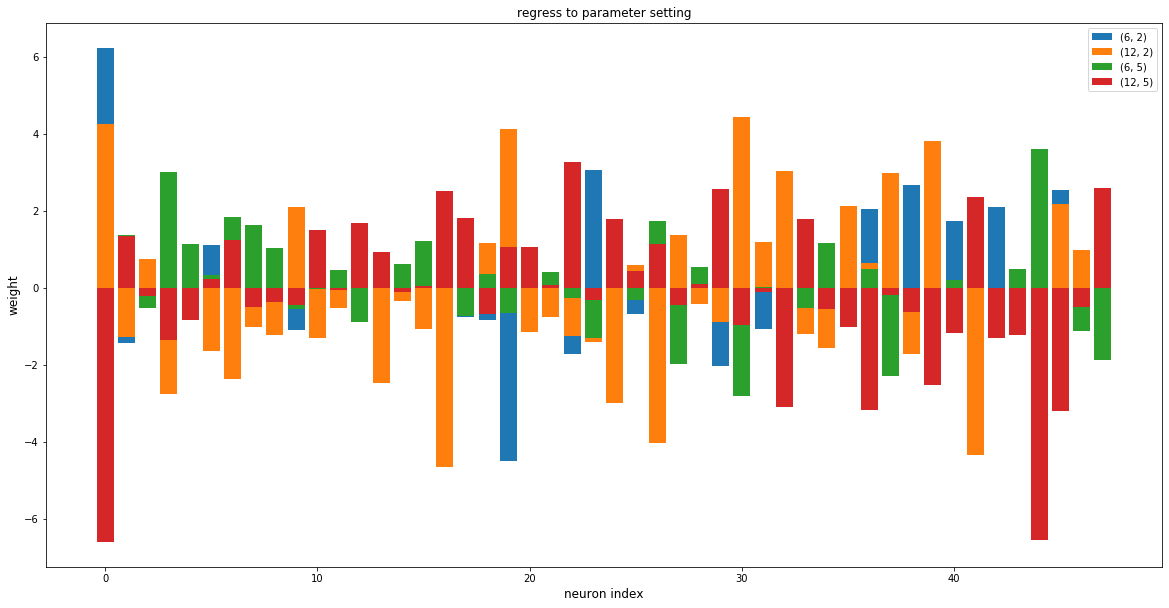

In [6]:
nn = False
if not nn:
    model = sklearn.linear_model.LogisticRegression(max_iter=1000).fit(X_train, Y_train)
else:
    model = sklearn.neural_network.MLPClassifier(max_iter=1000).fit(X_train, Y_train)
    
pred_train = model.predict(X_train)
print('train_acc', sum(pred_train==Y_train)/len(Y_train))
pred_test = model.predict(X_test)
print('test_acc', sum(pred_test==Y_test)/len(pred_test))

plt.figure(figsize=(20, 10))
coeff = model.coef_
for vec in coeff:
    plt.bar(np.arange(len(vec)), vec)
plt.legend(list(param_settings_idx.keys()))
plt.xlabel('neuron index', fontsize=12)
plt.ylabel('weight', fontsize=12)
plt.title('regress to parameter setting')

In [8]:
print(sklearn.metrics.confusion_matrix(Y_test, pred_test))
print(list(param_settings_idx.keys()))

[[ 4803   522  6635   148]
 [  842 11590   108  7716]
 [ 3956    45  8106  1263]
 [   21  2160  1199 10757]]
[(6, 2), (12, 2), (6, 5), (12, 5)]


## Regression Exploration/Exploitation

/home/joseph/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


train_acc 0.913162057882417
test_acc 0.9042608274456748


Text(0.5, 1.0, 'regress to network behavior')

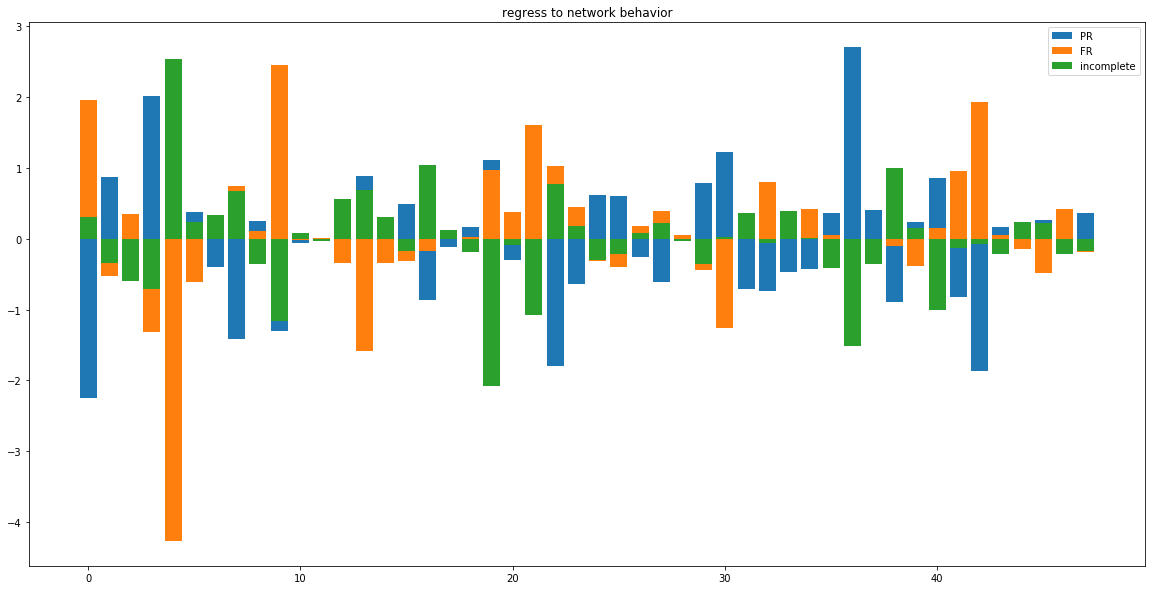

In [11]:
nn = False
if not nn:
    model = sklearn.linear_model.LogisticRegression(max_iter=1000).fit(X_train, tags_train)
else:
    model = sklearn.neural_network.MLPClassifier(max_iter=1000).fit(X_train, tags_train)

pred_train = model.predict(X_train)
print('train_acc', sum(pred_train==tags_train)/len(pred_train))
pred_test = model.predict(X_test)
print('test_acc', sum(pred_test==tags_test)/len(pred_test))

plt.figure(figsize=(20, 10))
coeff = model.coef_
for vec in coeff:
    plt.bar(np.arange(len(vec)), vec)
plt.legend(['PR', 'FR', 'incomplete'])
plt.title('regress to network behavior')

0 (6, 5)


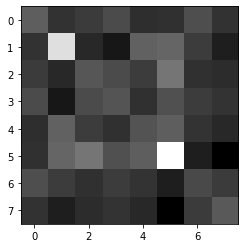

1 (6, 5)


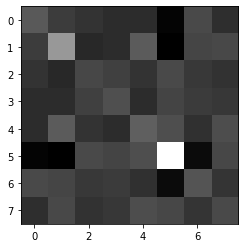

2 (6, 5)


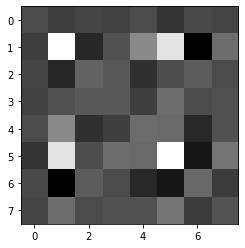

1 (6, 5)


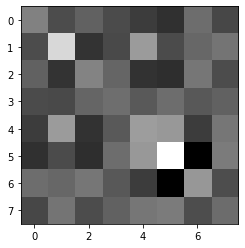

2 (6, 5)


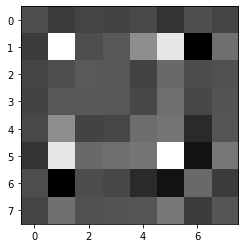

1 (6, 5)


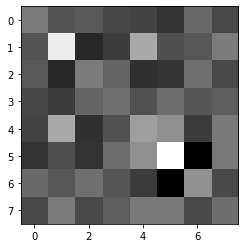

2 (6, 5)


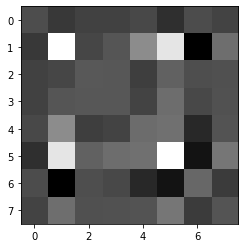

1 (6, 5)


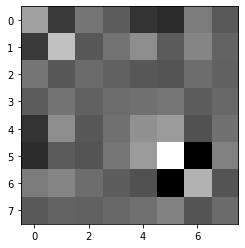

2 (6, 5)


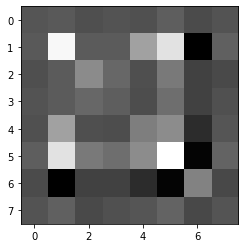

1 (6, 5)


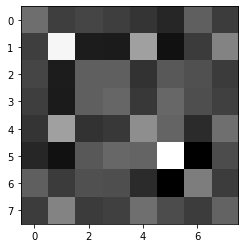

2 (6, 5)


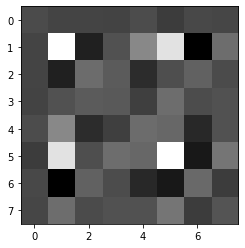

1 (6, 5)


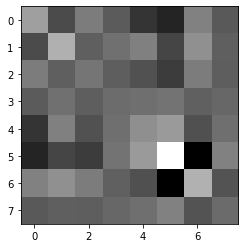

2 (6, 5)


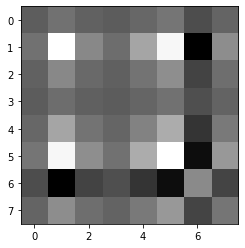

1 (6, 5)


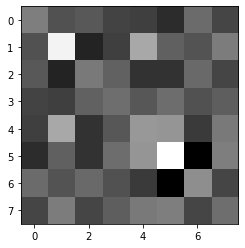

2 (6, 5)


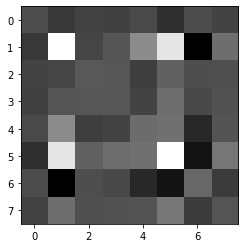

1 (6, 5)


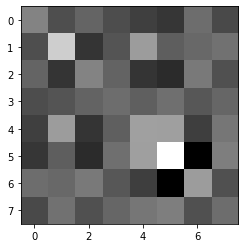

2 (6, 5)


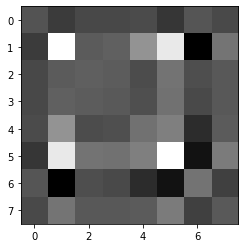

1 (6, 5)


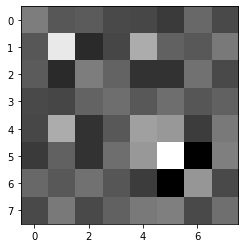

0 (6, 5)


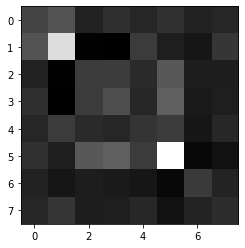

2 (6, 5)


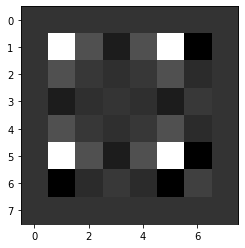

1 (12, 2)


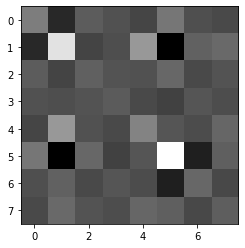

0 (12, 2)


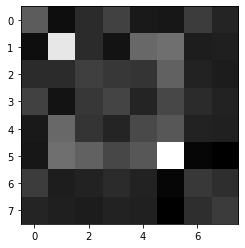

1 (12, 2)


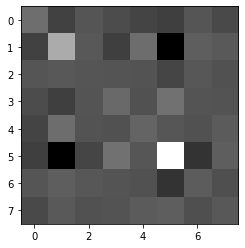

0 (12, 2)


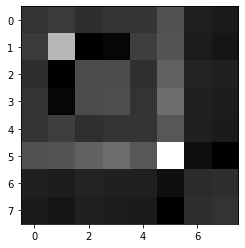

1 (12, 2)


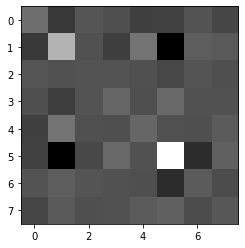

2 (12, 2)


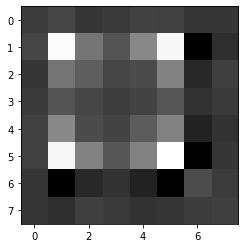

1 (12, 2)


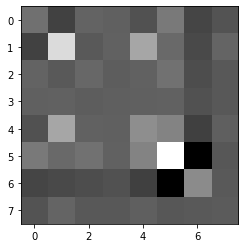

0 (12, 2)


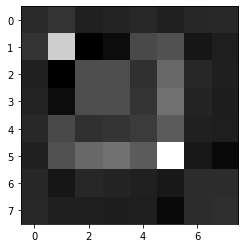

2 (12, 2)


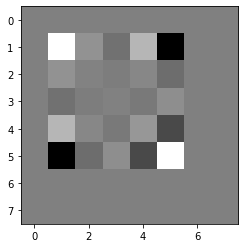

1 (12, 2)


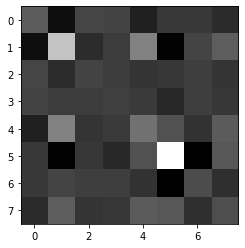

2 (12, 2)


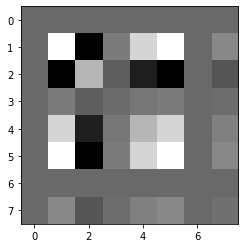

0 (12, 2)


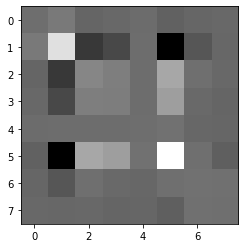

1 (12, 2)


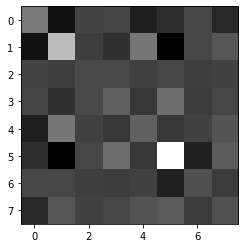

2 (12, 2)


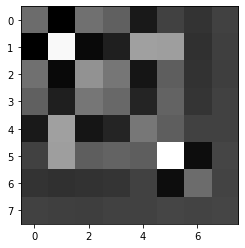

0 (12, 2)


KeyboardInterrupt: 

In [84]:
def get_correlation_matrix(clusters, activations):
    '''
        clusters: list of clusters, each list of indices in cluster
        activations: [num_neurons, T]
        returns:
            [num_clusters, num_clusters] matrix, each index if mean correlation between clusters
    '''
    matrix = np.zeros((len(clusters), len(clusters)))
    for i in range(len(clusters)):
        for j in range(len(clusters)):
            matrix[i, j] = compute_correlation(clusters[i], clusters[j], activations)
    return matrix
        
def compute_correlation(cluster1_idx, cluster2_idx, activations, mean=True):
    '''
        cluster1_idx: list of neurons in cluster 1
        cluster2_idx: list of neurons in cluster 2
        activations: [num_neurons, T]
        returns:
            matrix of correlation [cluster1_idx, cluster2_idx]
            or mean of above matrix
    '''
    corr = np.zeros((len(cluster1_idx), len(cluster2_idx)))
    for i in range(len(cluster1_idx)):
        for j in range(len(cluster2_idx)):
            corr[i, j] = np.corrcoef(activations[cluster1_idx[i]], activations[cluster2_idx[j]])[0, 1]
    if mean:
        return np.mean(corr)
    else:
        return corr
angles = np.angle(coeff[0] + 1j * coeff[1], deg=True) # angle for each neuron
magnitudes = np.abs(coeff[0] + 1j * coeff[1]) # how should I use this?
bins = np.digitize(angles, np.arange(-135, 180, 45))
clusters = [np.where(bins==i)[0] for i in range(8)]
current_chunk = [] # current chunk activations, 'chunk' being a contiguous chunk of trials with same choices
for i in range(len(tags) - 1):
    current_chunk.append(X[i])
    if tags[i] != tags[i + 1]: # if trial type switchs
        current_chunk = np.stack(current_chunk, axis=1)
        cluster_correlations = get_correlation_matrix(clusters, current_chunk)
        print(tags[i], param_settings[Y[i]])
        plt.figure()
        plt.imshow(cluster_correlations, cmap='gray')
        plt.show()
        #print(cluster_correlations)
        current_chunk = []

## Regress to num_pressed

train_acc 0.642560135120628
test_acc 0.6246910694008416


Text(0.5, 1.0, 'regression coefficient on number of presses')

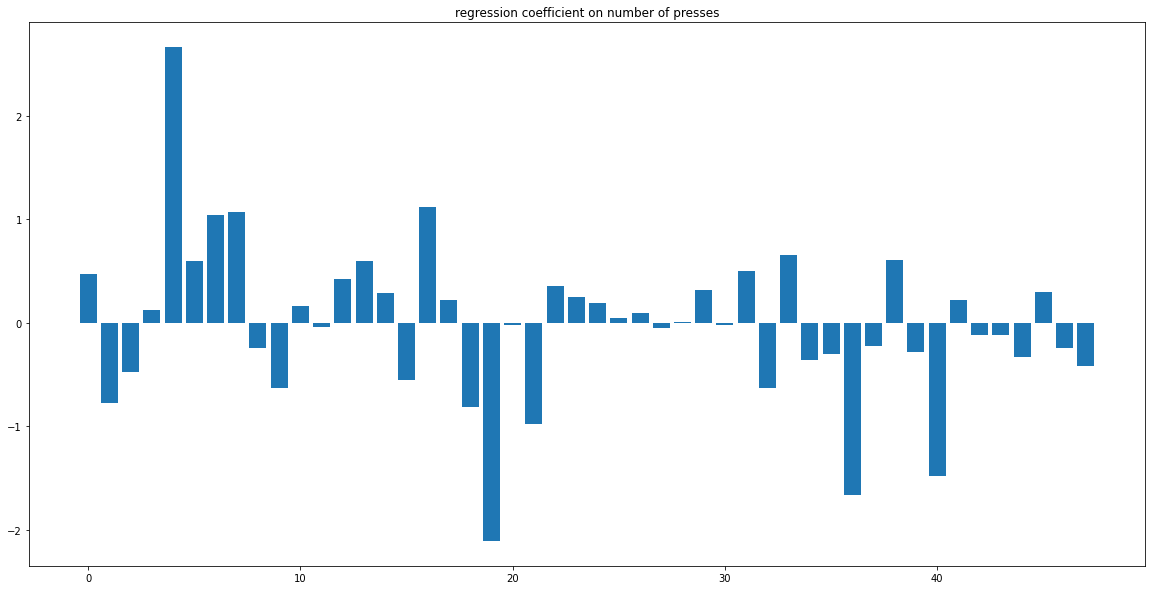

In [9]:
nn = False # switching to nn yields 95% test accuracy
if not nn:
    model = sklearn.linear_model.LinearRegression().fit(X_train, num_pressed_train)
else:
    model = sklearn.neural_network.MLPRegressor(max_iter=1000).fit(X_train, num_pressed_train)

pred_train = model.predict(X_train)
print('train_acc', sum(np.around(pred_train)==num_pressed_train)/len(num_pressed_train))
pred_test = model.predict(X_test)
print('test_acc', sum(np.around(pred_test)==num_pressed_test)/len(num_pressed_test))

plt.figure(figsize=(20, 10))
coeff = model.coef_
plt.bar(np.arange(len(vec)), vec)
plt.title('regression coefficient on number of presses')


session: 0 reward: 0.158
[(6, 5), (6, 2), (12, 2)]
session: 0 reward: 0.1545
[(6, 5), (6, 2), (12, 2)]


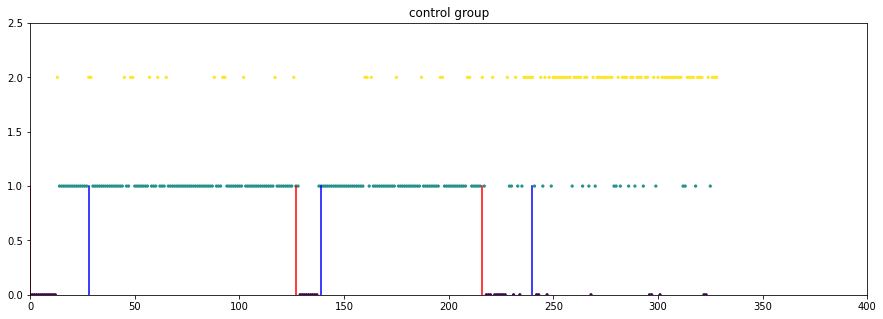

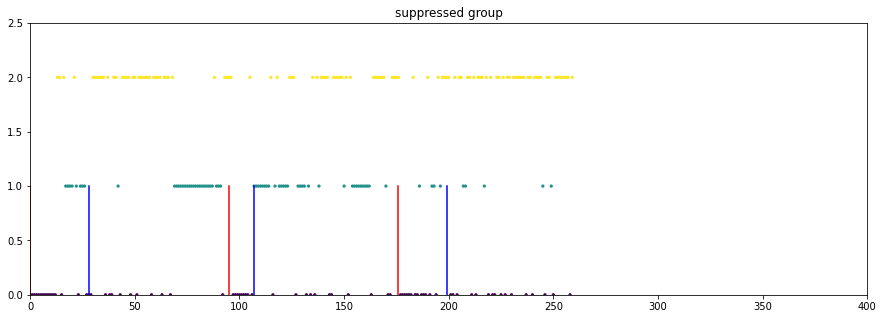

In [31]:
suppress_index = [0, 18, 19, 36, 44, 45, 39, 36]

optimal_switch = {(6, 2):10, (12, 2):22, (6, 5):28, (12, 5):58} #a*b-2
# control group
np.random.seed(12345)
experiment = lever()
actions, rewards, value_preds = run_session(experiment, agent, optimizer, 0, train = False, suppress_index=[])
resets = experiment.resets
params = experiment.parameters
trials, trial_tags, trial_activ = count_trials(actions, rewards, agent.activ_hist)
plt.figure(figsize = (15, 5))
scatter = plt.scatter(np.arange(len(trial_tags)), trial_tags, s = 5, c = trial_tags)
for reset, param in zip(resets, params):
    trial_to_presses = np.cumsum([len(trial) for trial in trials])
    reset_trial = np.searchsorted(trial_to_presses, reset)
    plt.plot([reset_trial, reset_trial], [0, 1], color='red')
    for trial_num in range(reset_trial, len(trial_tags)):
        if trial_tags[trial_num] == 0:
            optimal_switch_trial_num = trial_num + optimal_switch[param]
            break
    plt.plot([optimal_switch_trial_num, optimal_switch_trial_num], [0, 1], color='blue')
plt.title('control group')
plt.ylim((0, 2.5))
plt.xlim((0, 400))
print(experiment.parameters)

# suppressed group
np.random.seed(12345)
experiment = lever()
actions, rewards, value_preds = run_session(experiment, agent, optimizer, 0, train = False, suppress_index=suppress_index)
resets = experiment.resets
params = experiment.parameters
trials, trial_tags, trial_activ = count_trials(actions, rewards, agent.activ_hist)
plt.figure(figsize = (15, 5))
scatter = plt.scatter(np.arange(len(trial_tags)), trial_tags, s = 5, c = trial_tags)
for reset, param in zip(resets, params):
    trial_to_presses = np.cumsum([len(trial) for trial in trials])
    reset_trial = np.searchsorted(trial_to_presses, reset)
    plt.plot([reset_trial, reset_trial], [0, 1], color='red')
    for trial_num in range(reset_trial, len(trial_tags)):
        if trial_tags[trial_num] == 0:
            optimal_switch_trial_num = trial_num + optimal_switch[param]
            break
    plt.plot([optimal_switch_trial_num, optimal_switch_trial_num], [0, 1], color='blue')
plt.title('suppressed group')
plt.ylim((0, 2.5))
plt.xlim((0, 400))
print(experiment.parameters)

## Visualize

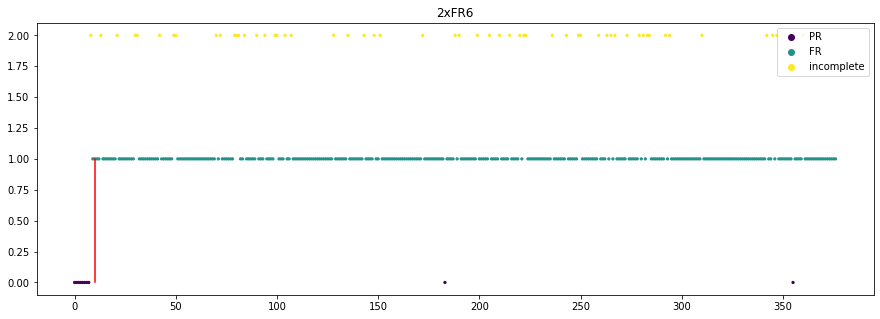

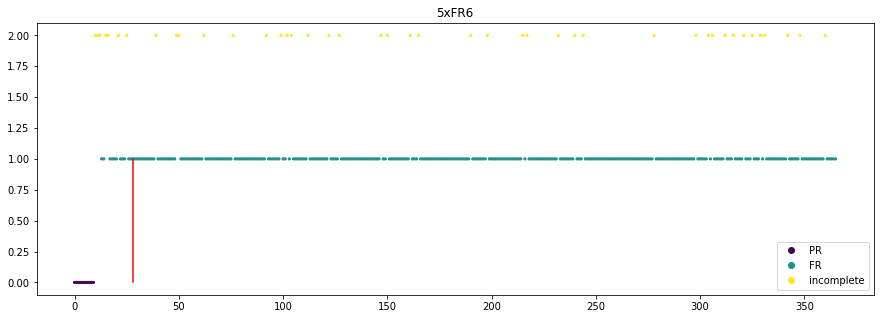

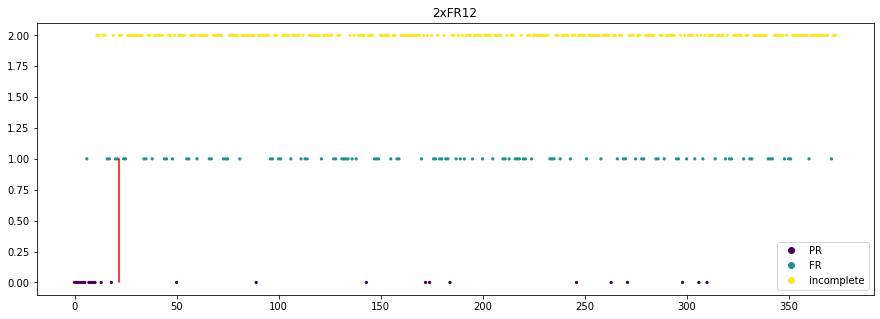

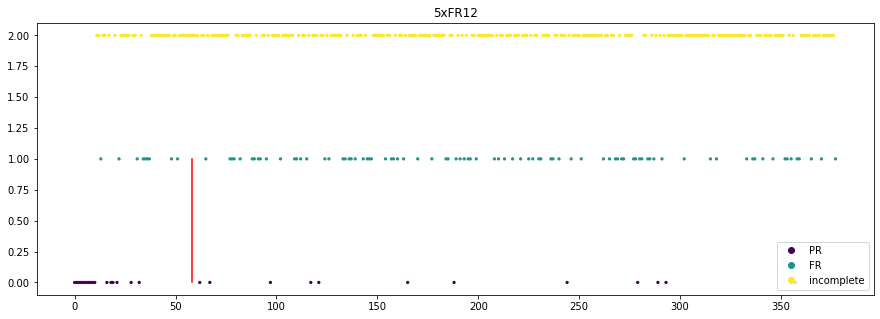

In [6]:
for (FR_limit, PR_reward), sessions in d.items():
    example_actions, example_rewards, example_value_preds, example_activ_hist = sessions[np.random.randint(len(sessions))]
    trials, trial_tags, trial_activ = count_trials(example_actions, example_rewards, example_activ_hist)
    plt.figure(figsize = (15, 5))
    scatter = plt.scatter(np.arange(len(trial_tags)), trial_tags, s = 5, c = trial_tags)
    plt.legend(handles=scatter.legend_elements()[0], labels=['PR', 'FR', 'incomplete'])
    plt.title('%dxFR%d'%(PR_reward, FR_limit))
    # add optimal line
    switch_time = optimal_switch[(FR_limit, PR_reward)]
    plt.plot([switch_time, switch_time], [0, 1], color='red')

## Analyze the contrast between exploration and exploitation trials
### We define exploration as incomplete trials, exploitation as complete trials

Text(0, 0.5, 'F-score')

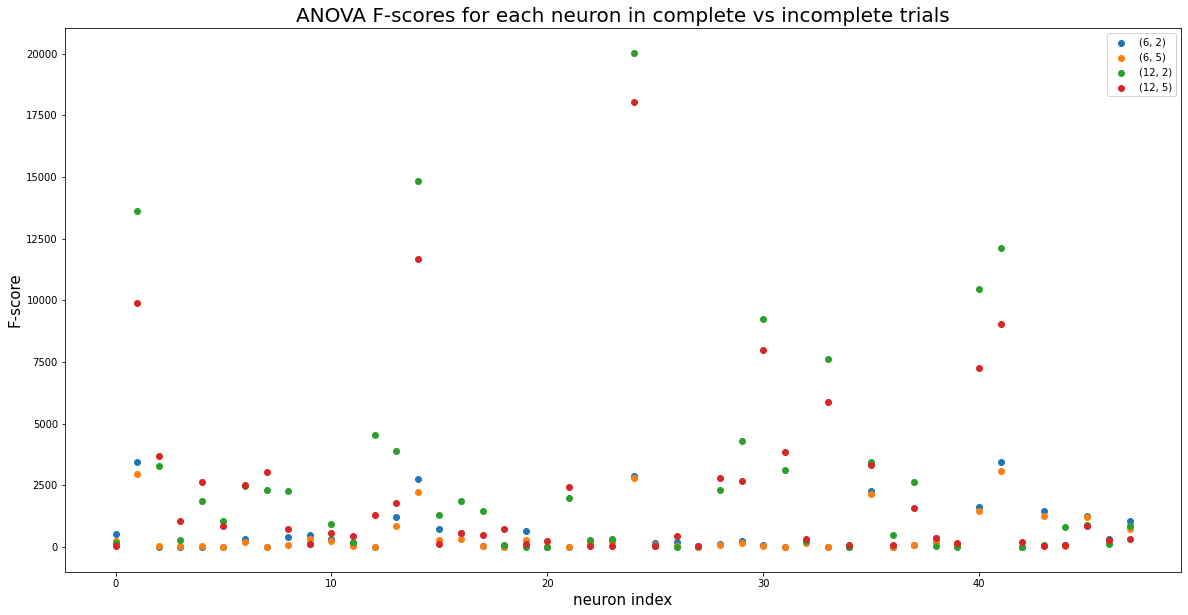

In [51]:
plt.figure(figsize=(20, 10))
plots = []
exploration_activs = {} # key: param value: neuron history
exploitation_activs = {}
for (FR_limit, PR_reward), sessions in d.items(): # for each parameter setting
    exploration_activ, exploitation_activ = [], []
    for (actions, rewards, value_preds, activ_hist) in sessions: # for each session under a setting
        trials, trial_tags, trial_activ = count_trials(actions, rewards, activ_hist)
        exploration_activ += ([trial_activ[i] for i in range(len(trial_tags)) if trial_tags[i] == 2])
        exploitation_activ += ([trial_activ[i] for i in range(len(trial_tags)) if trial_tags[i] != 2])
    exploration_activ = np.concatenate(exploration_activ)
    exploration_activs[(FR_limit, PR_reward)] = exploration_activ
    exploitation_activ = np.concatenate(exploitation_activ)
    exploitation_activs[(FR_limit, PR_reward)] = exploitation_activ
    f_score, p_value = f_oneway(exploration_activ, exploitation_activ)
    plots.append(plt.scatter(np.arange(len(f_score)), f_score))
plt.title('ANOVA F-scores for each neuron in complete vs incomplete trials', fontsize=20)
#plots.append(plt.plot([0, len(f_score)], [f_score.mean(), f_score.mean()], color='red')[0])
plt.legend(plots, list(d.keys())+['global mean'])
plt.xlabel("neuron index", fontsize=15)
plt.ylabel("F-score", fontsize=15)


/home/joseph/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


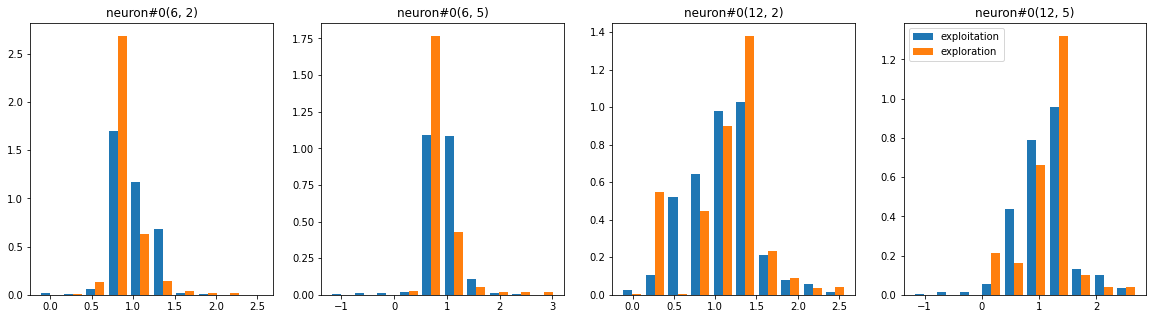

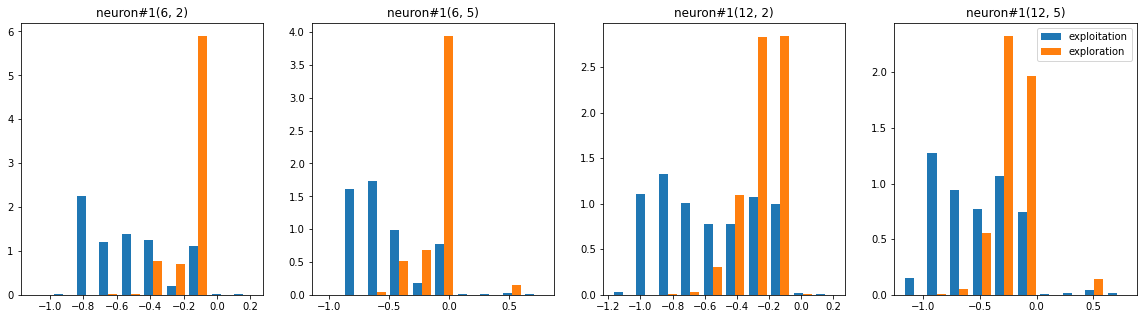

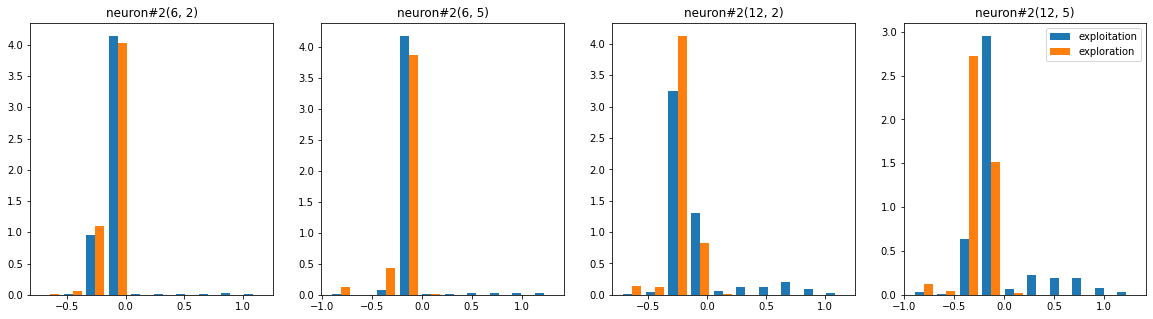

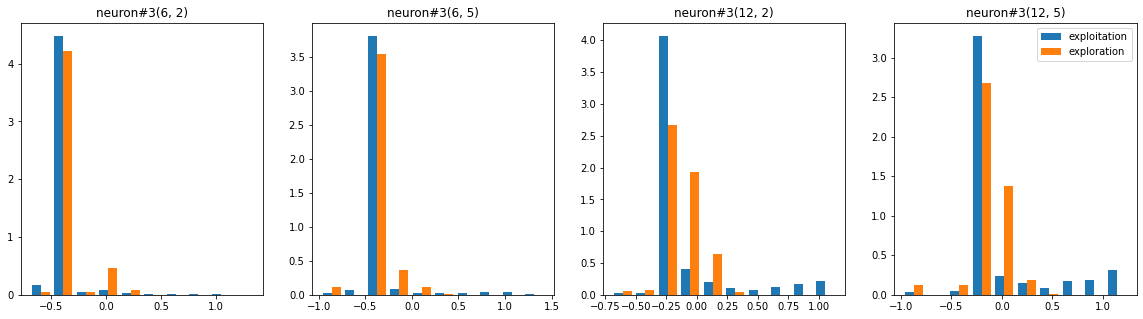

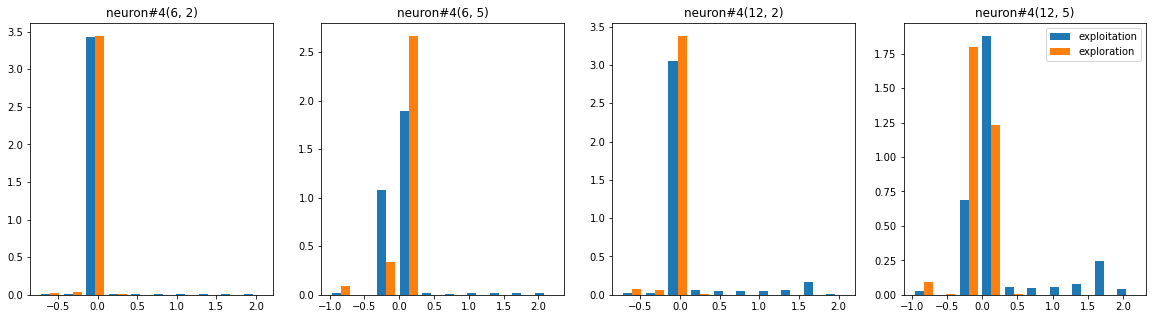

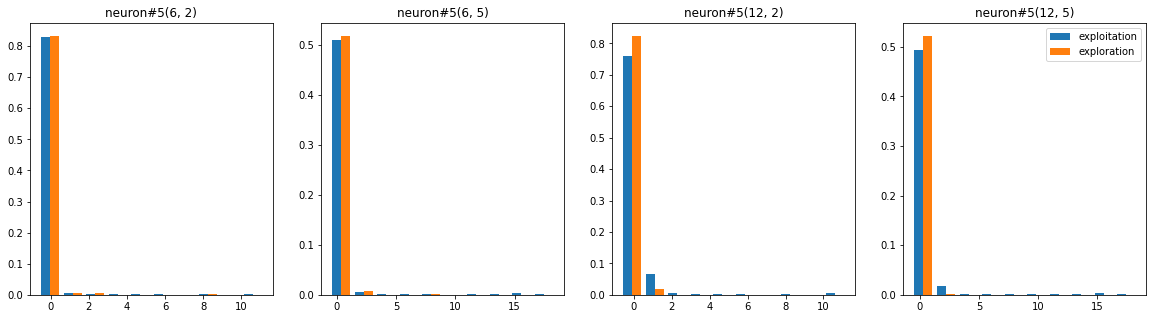

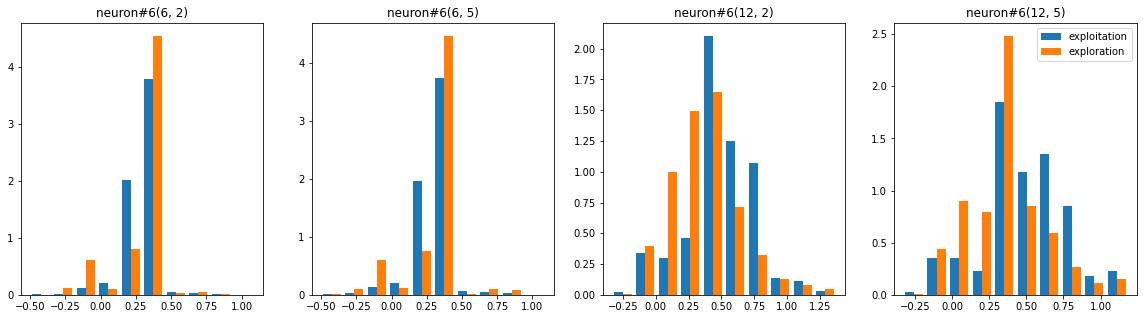

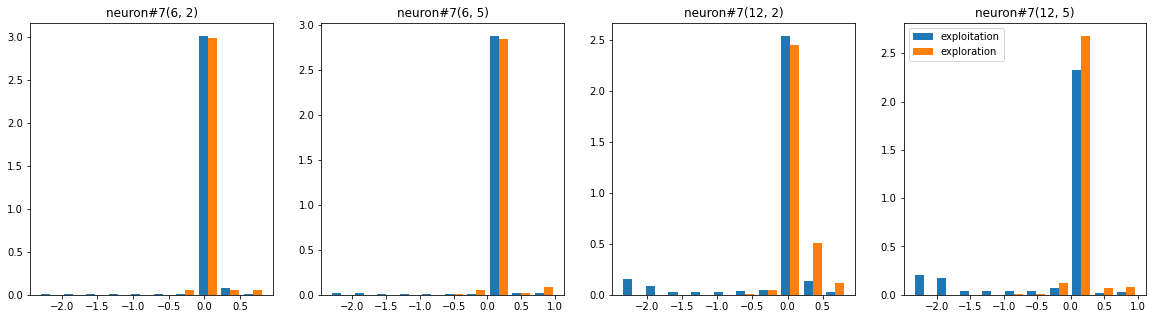

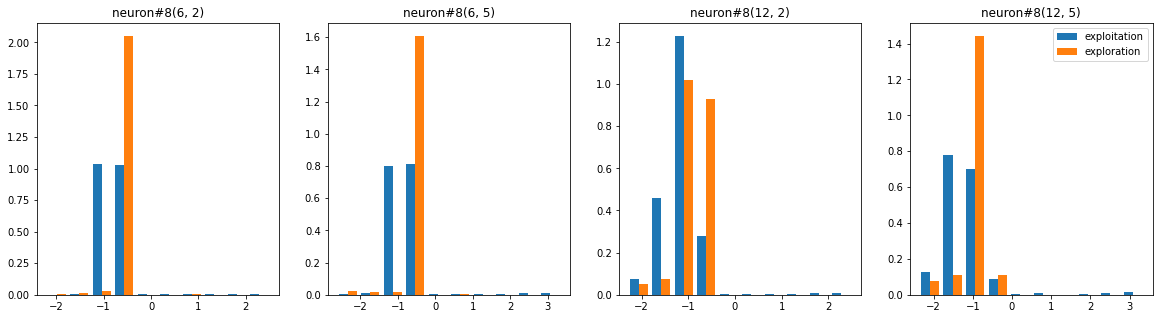

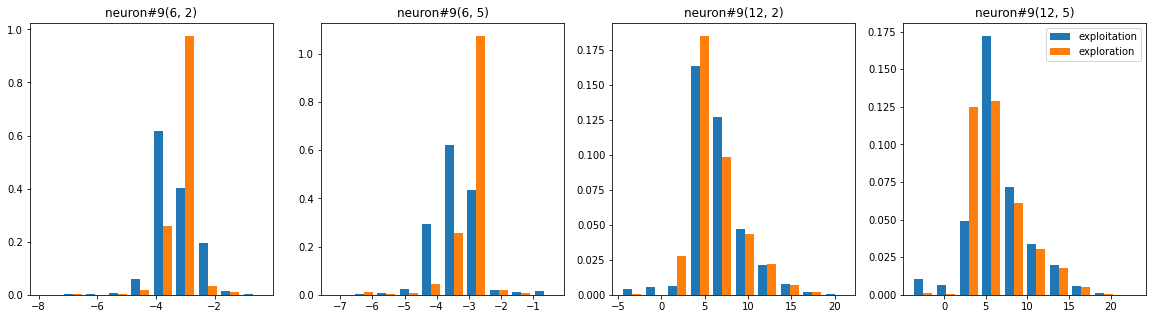

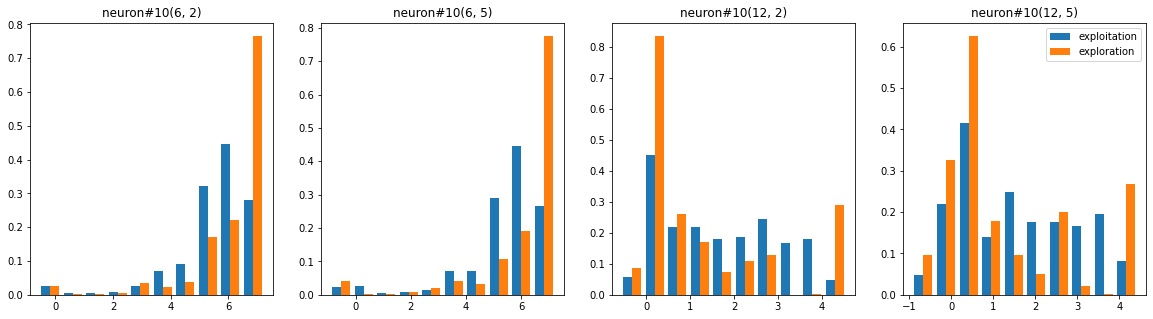

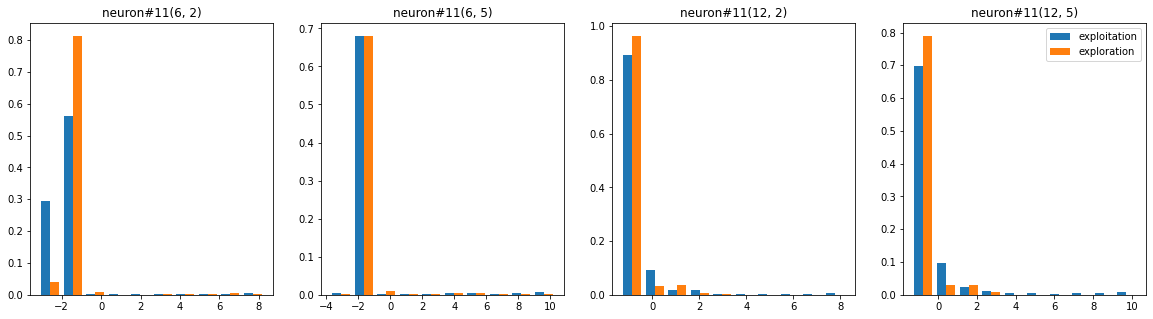

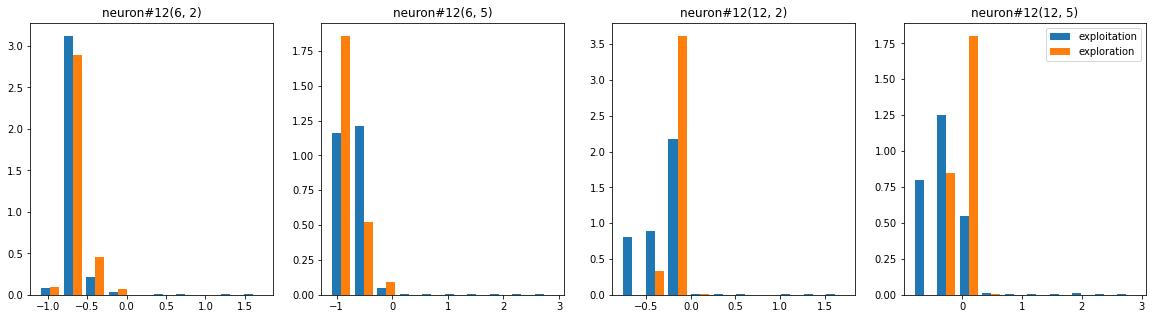

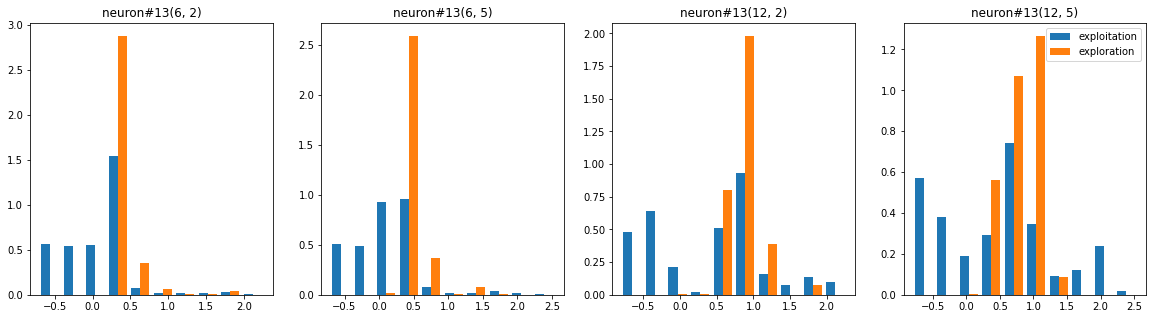

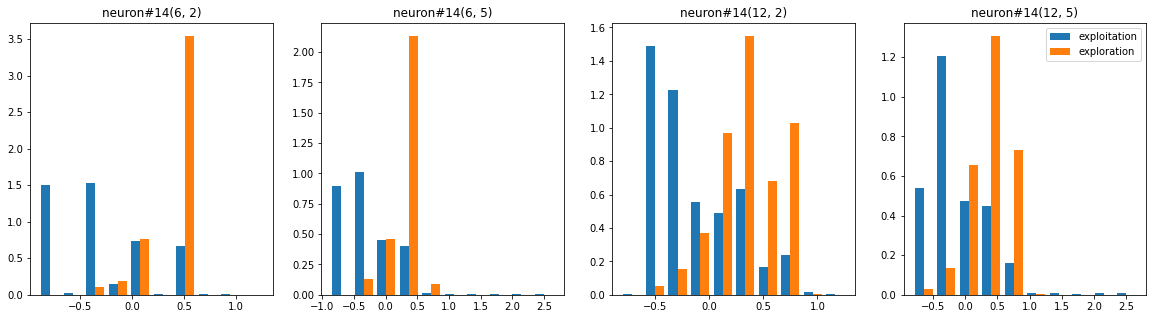

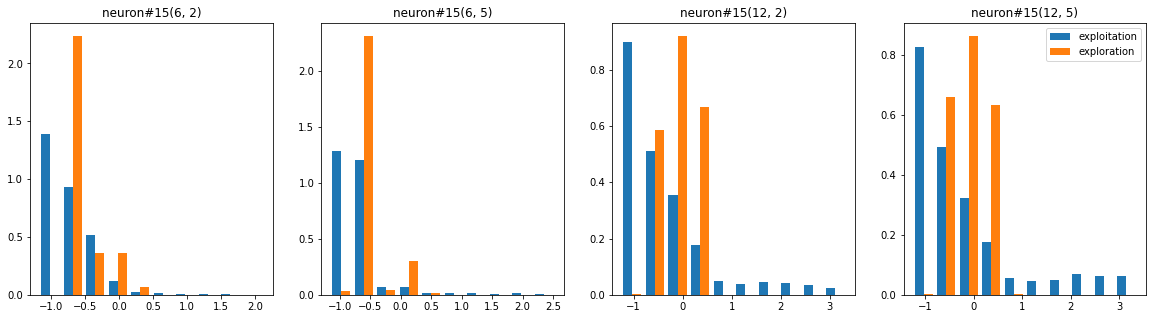

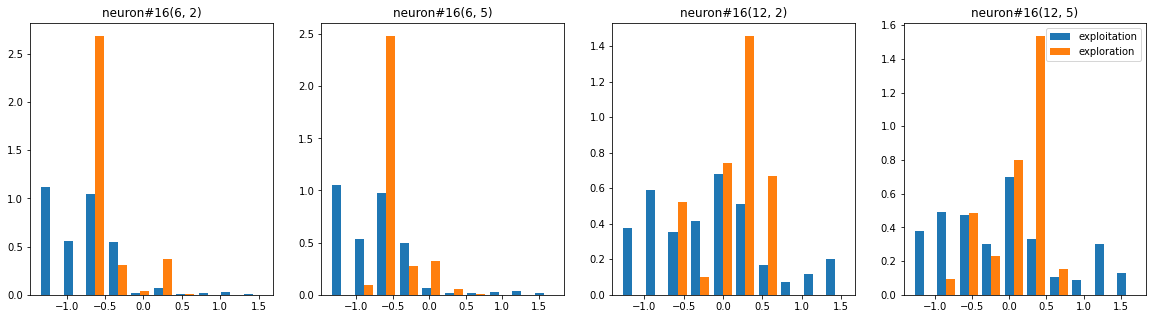

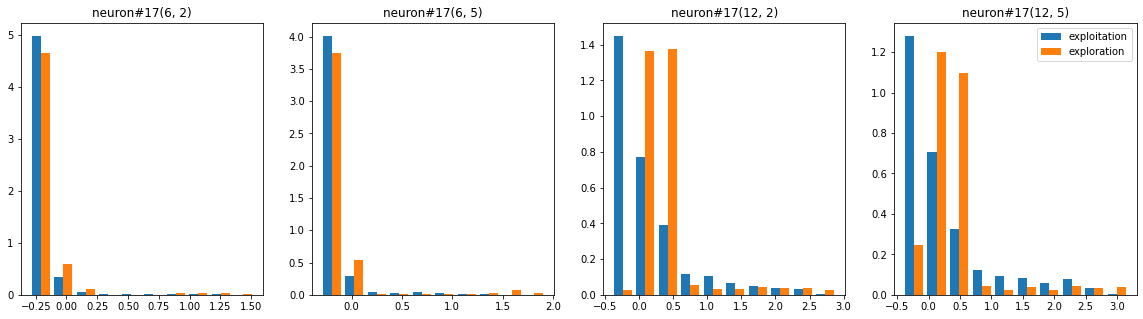

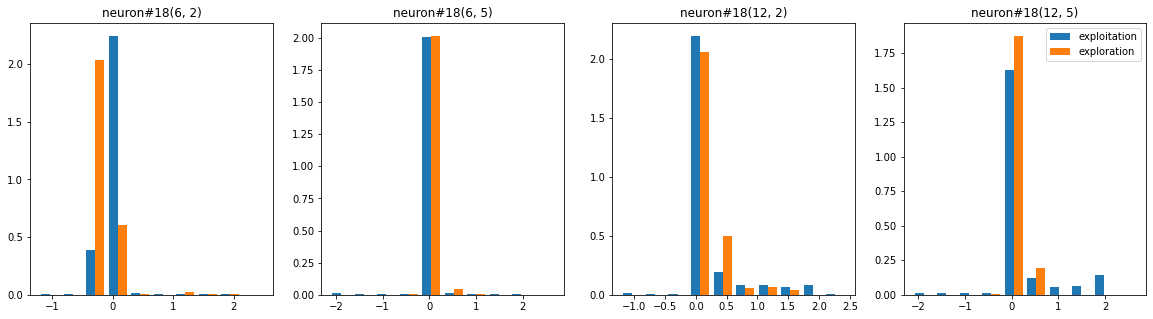

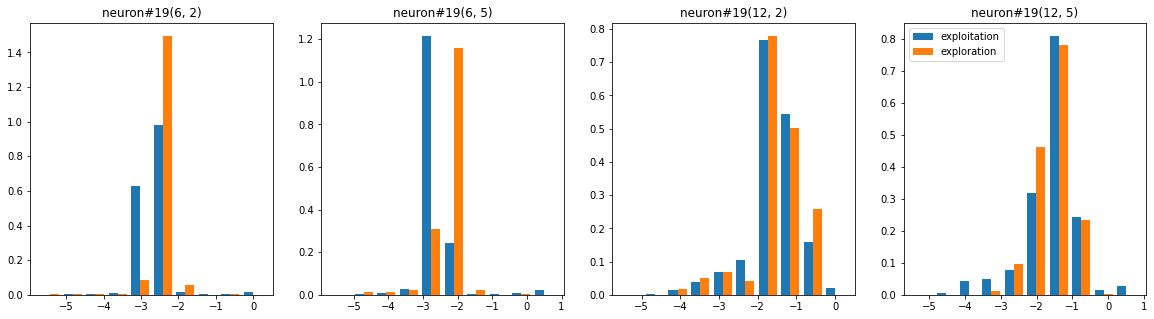

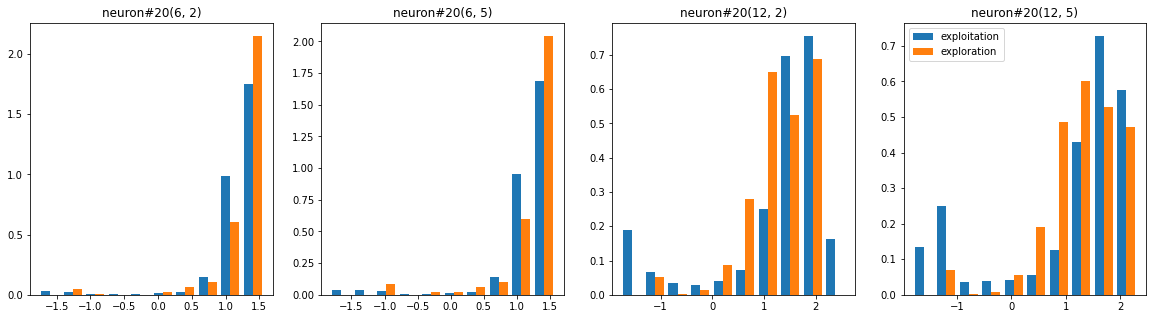

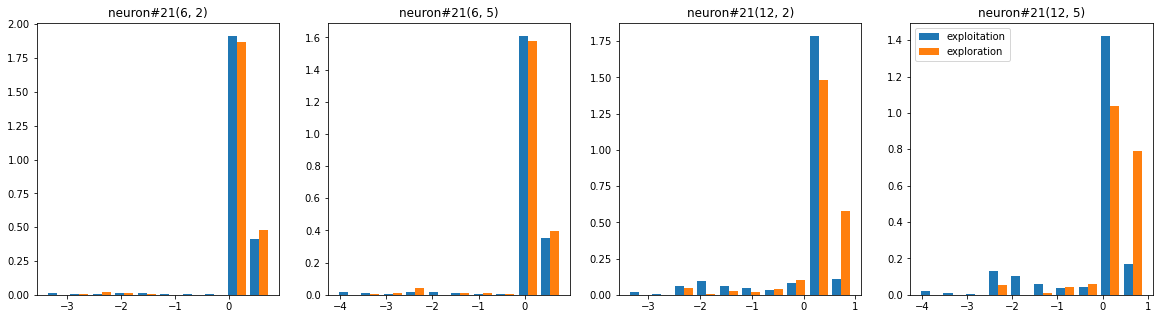

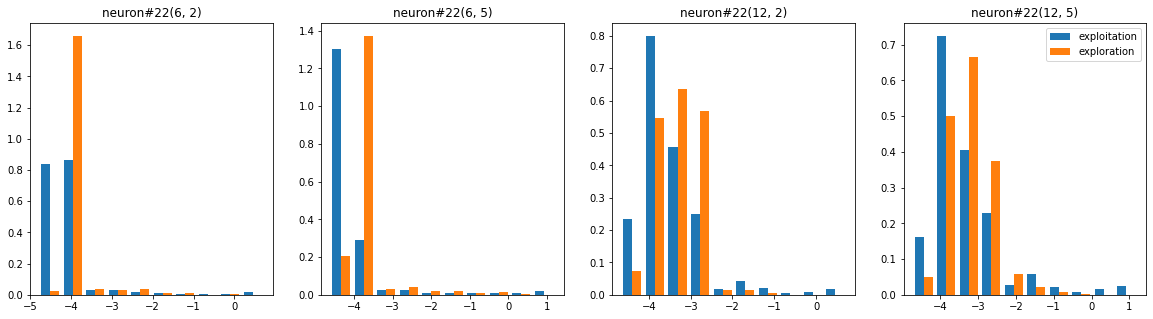

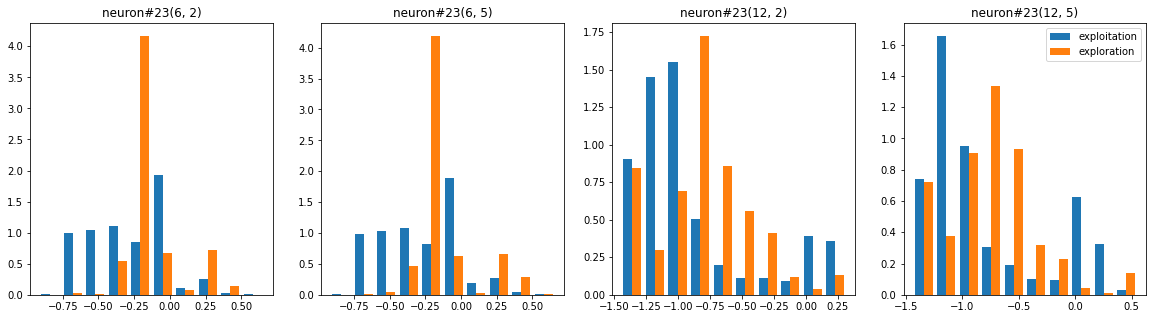

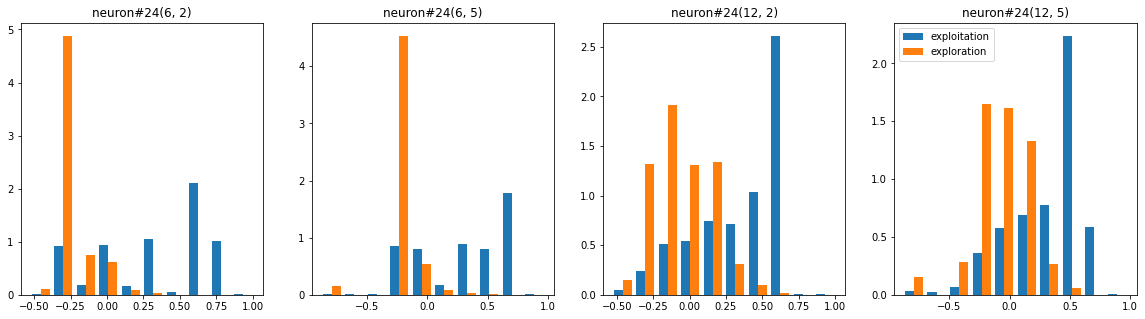

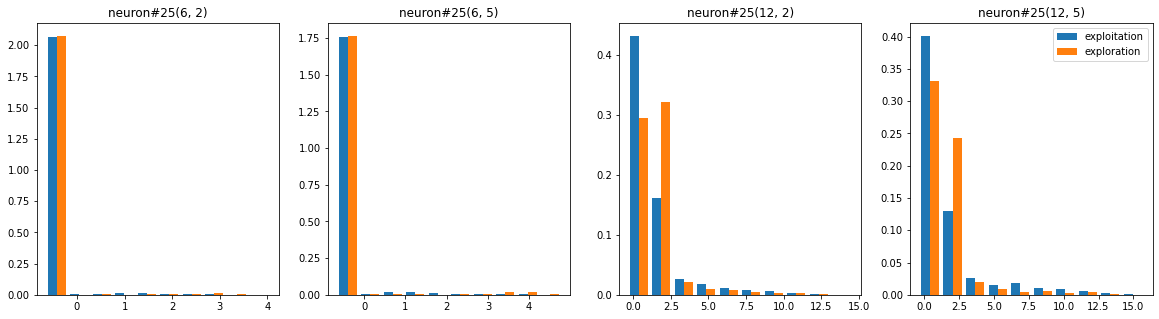

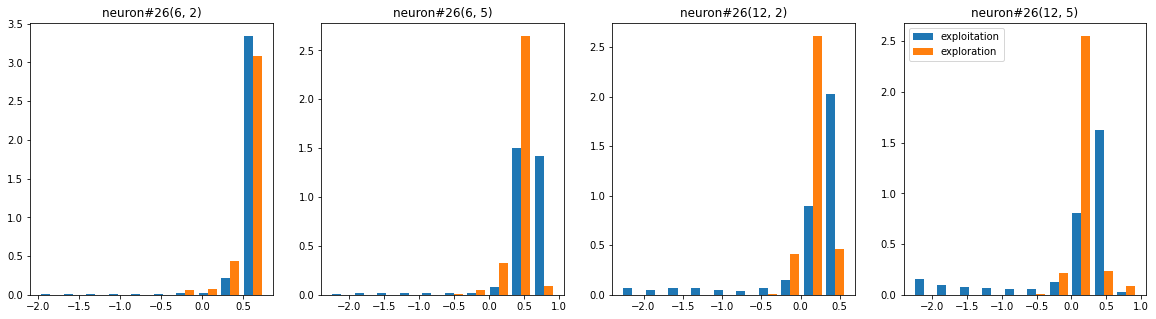

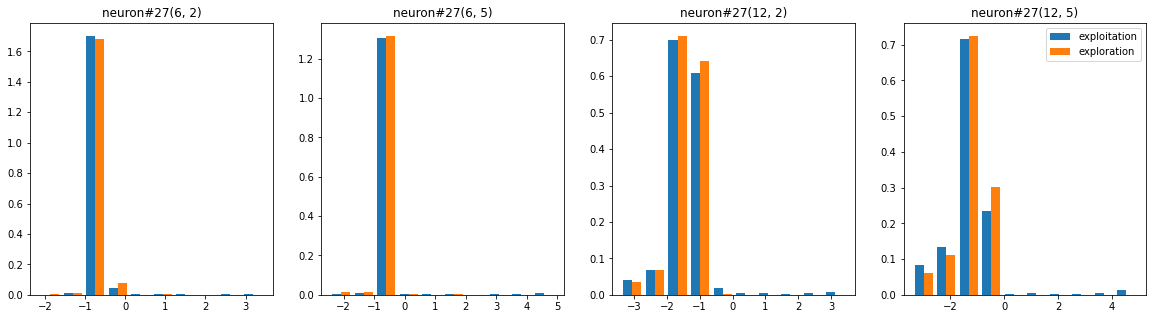

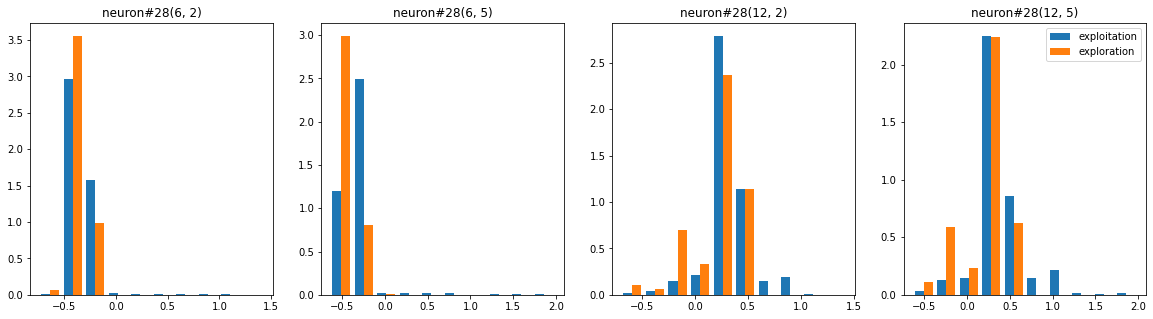

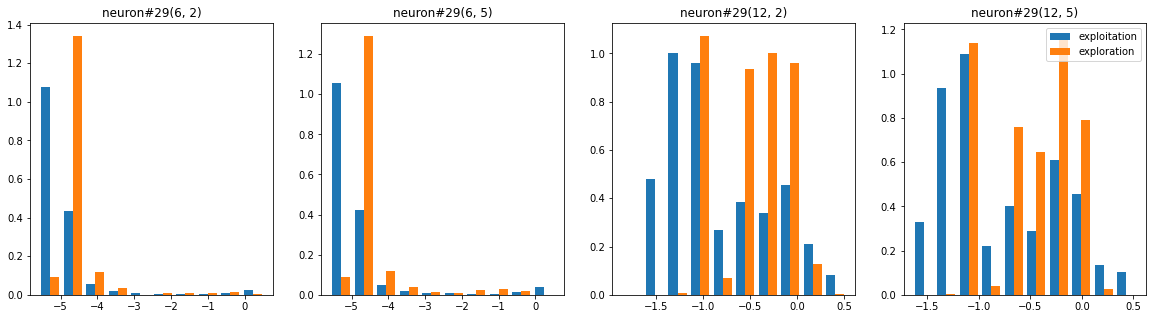

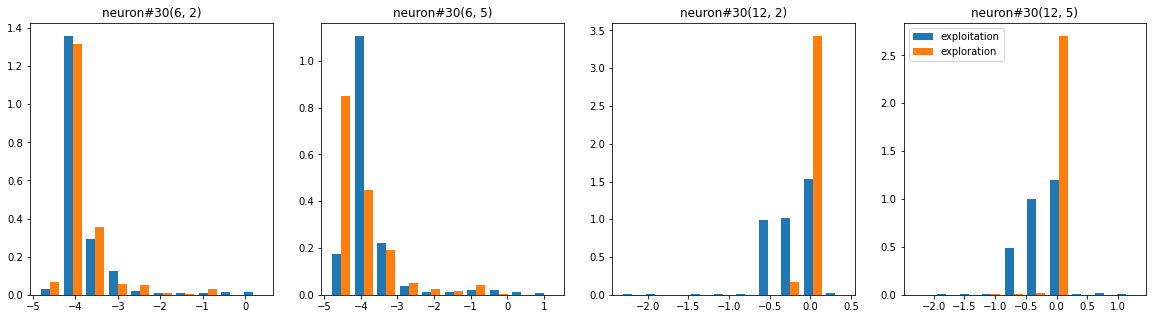

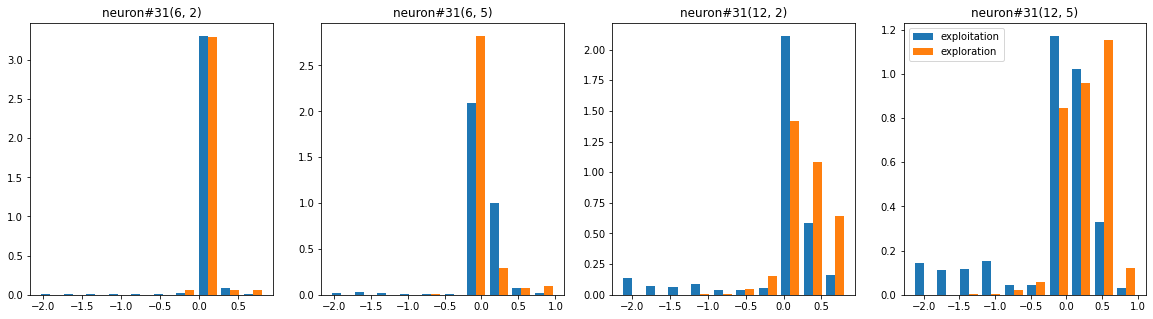

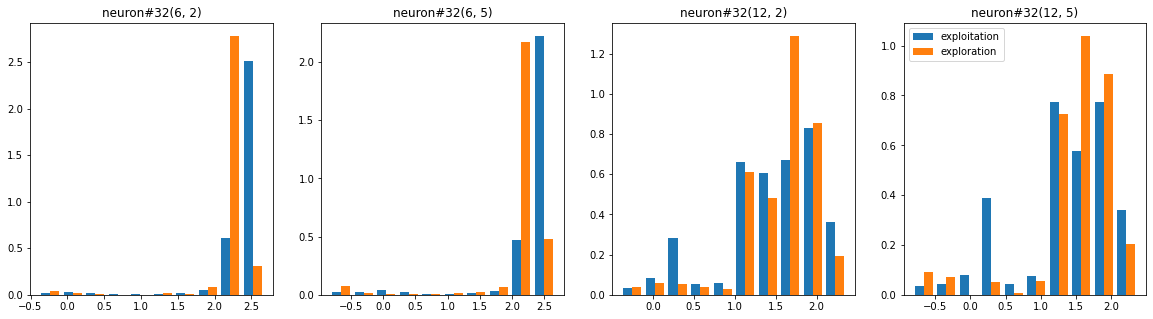

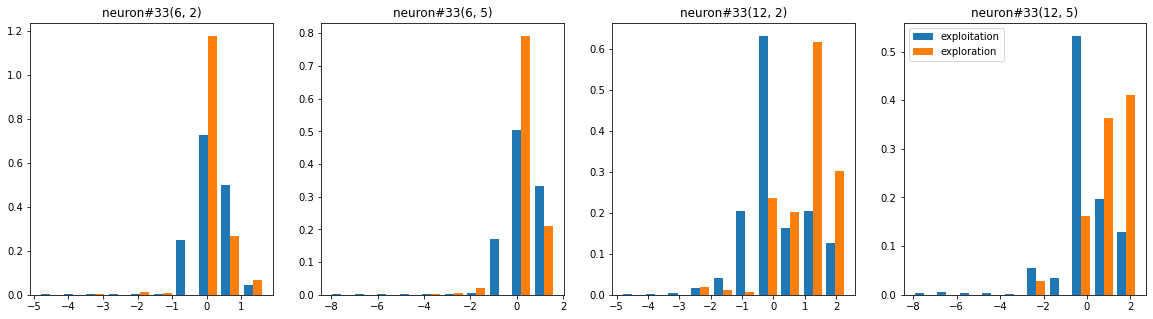

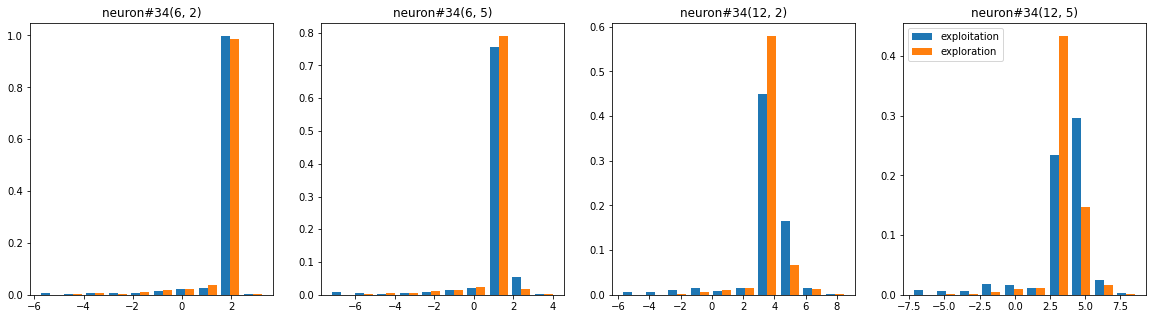

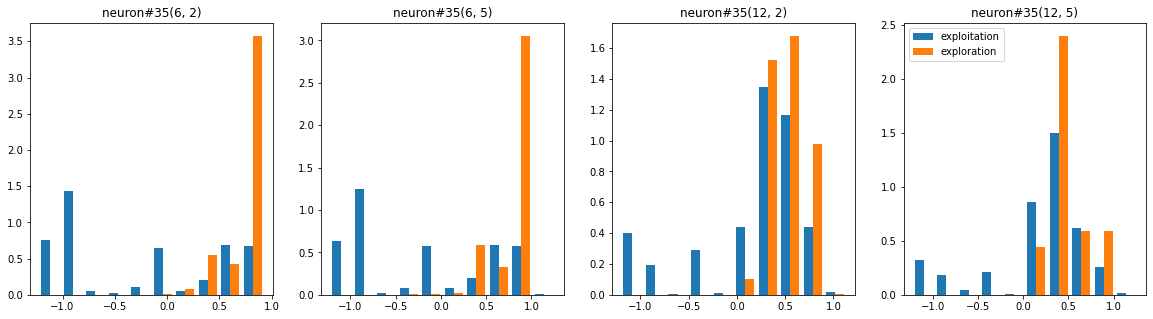

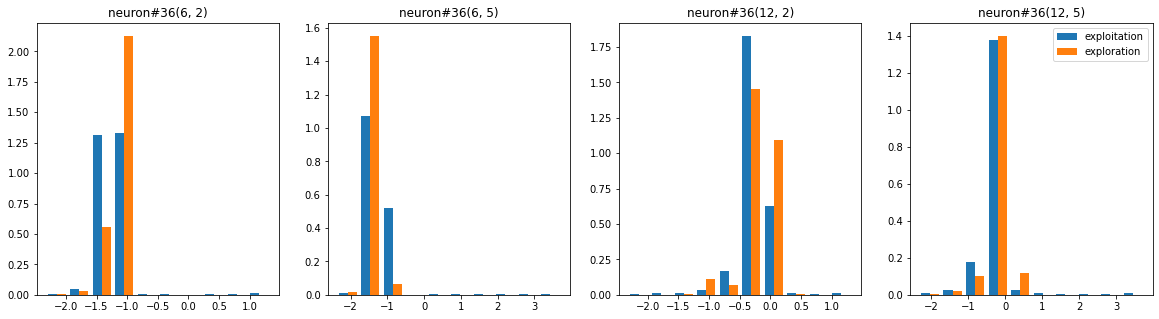

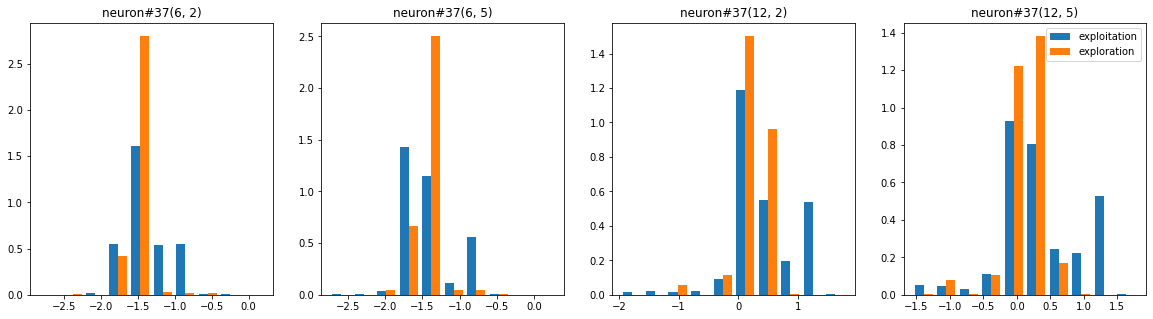

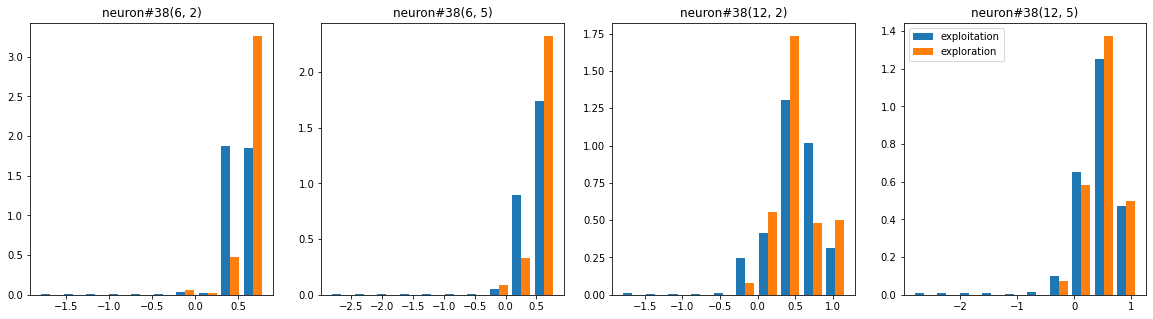

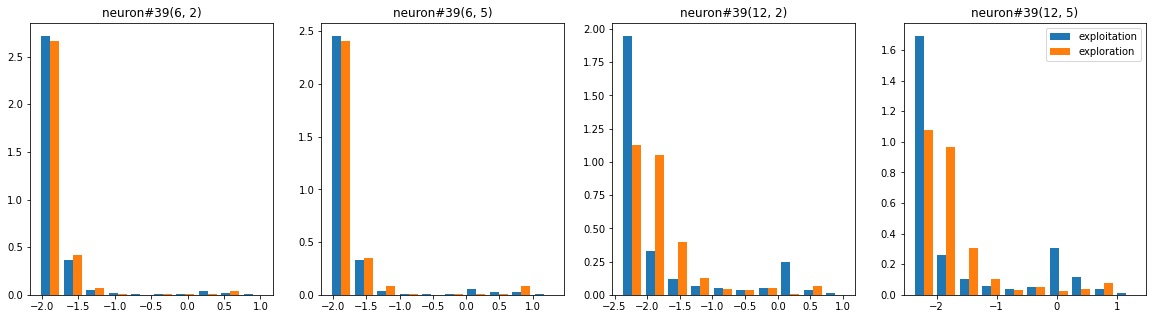

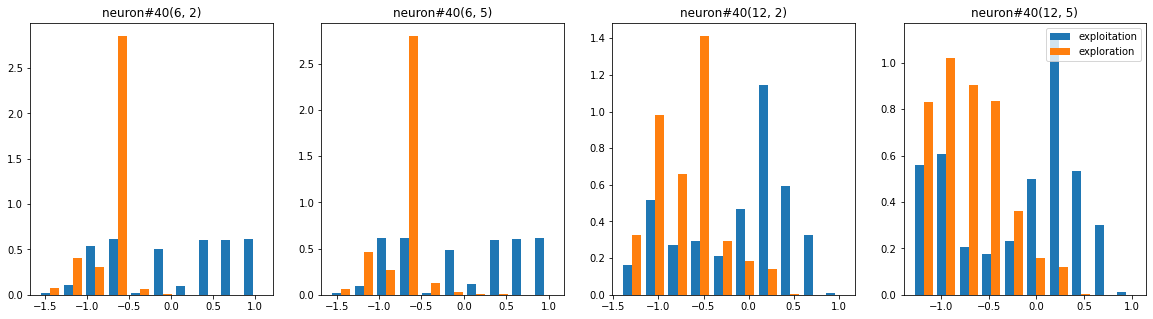

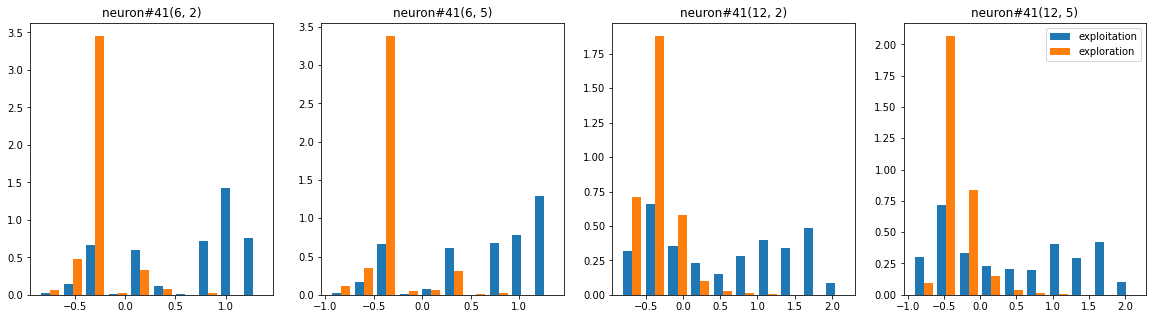

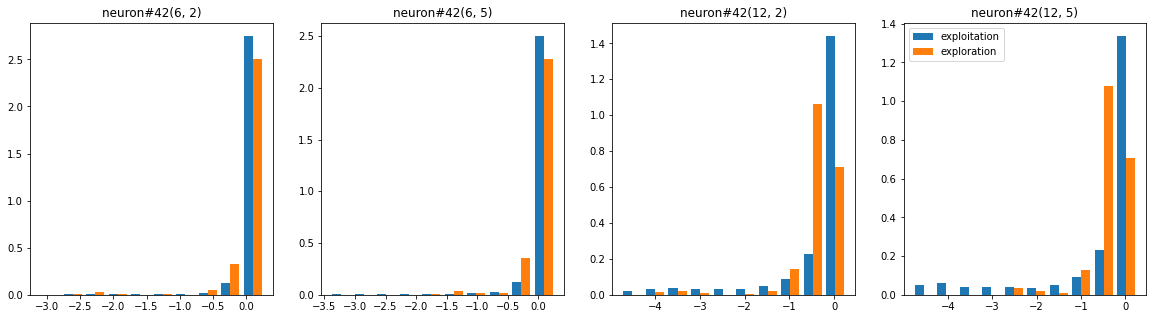

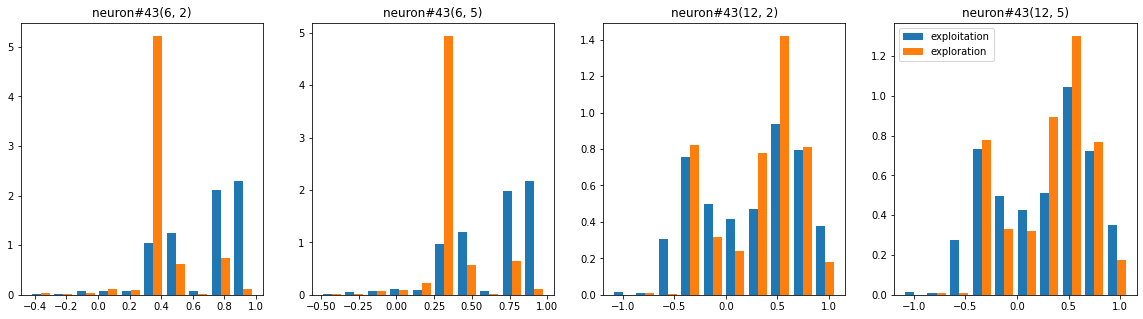

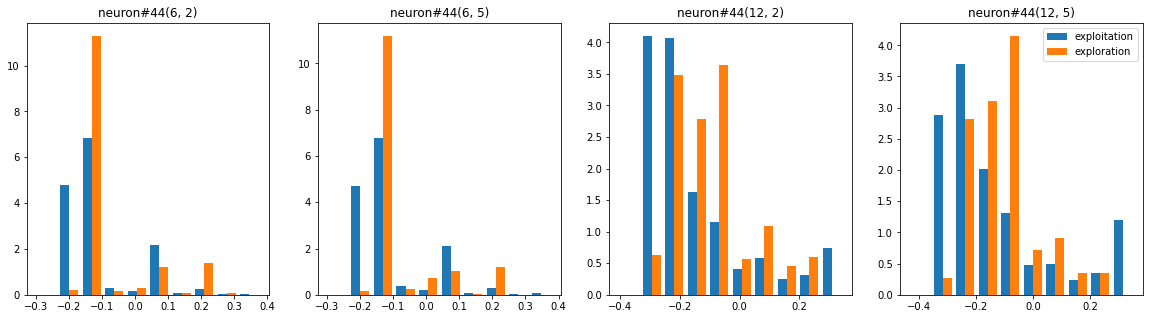

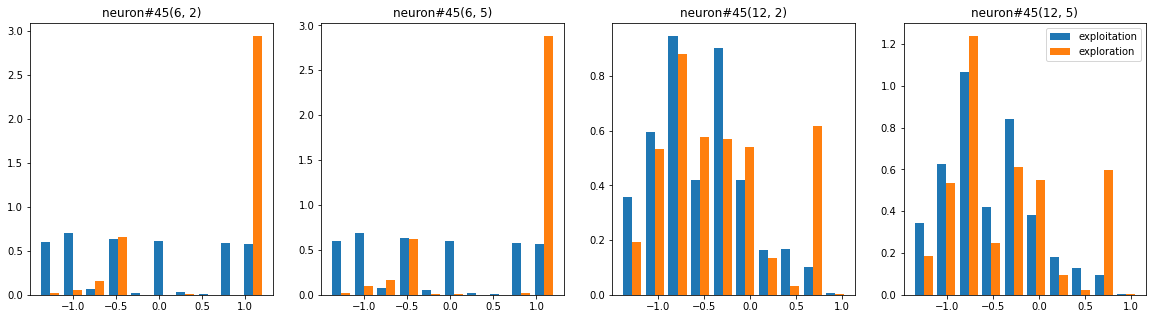

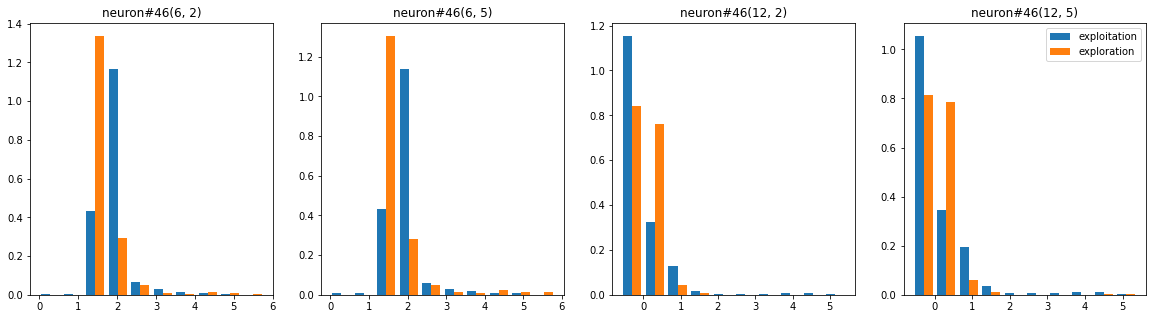

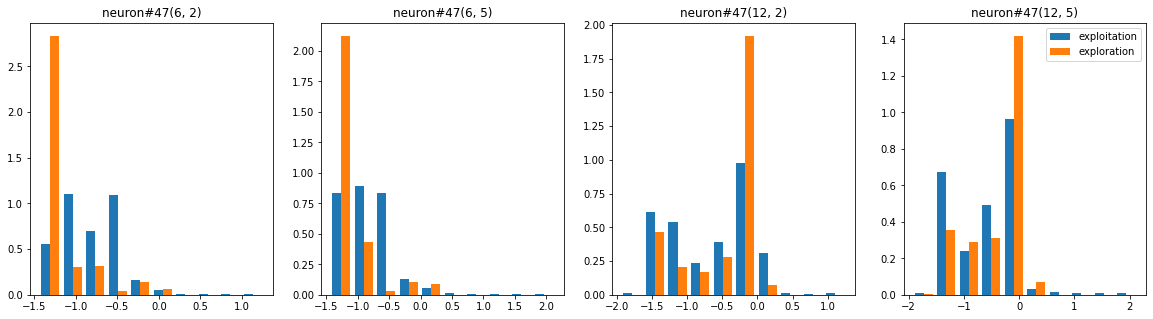

In [8]:
for idx in range(48):
    plt.figure(figsize=(20, 5))
    for i, key in enumerate(d.keys()):
        plt.subplot(1, 4, i+1)
        exploitation_activ = exploitation_activs[key]
        exploration_activ = exploration_activs[key]
        plt.hist((exploitation_activ[:, idx], exploration_activ[:, idx]), density=True)
        plt.title("neuron#"+str(idx)+(str(key)))
    plt.legend(['exploitation', 'exploration'])
    plt.show()

## Hypothesis: Maybe the current trial press count is based on the value solely? Or is there some neuron counting unrewarded presses?
## Unsurprisingly, value pred in FR trials remains same regardless of PR reward magnitude, but varies due to cost?

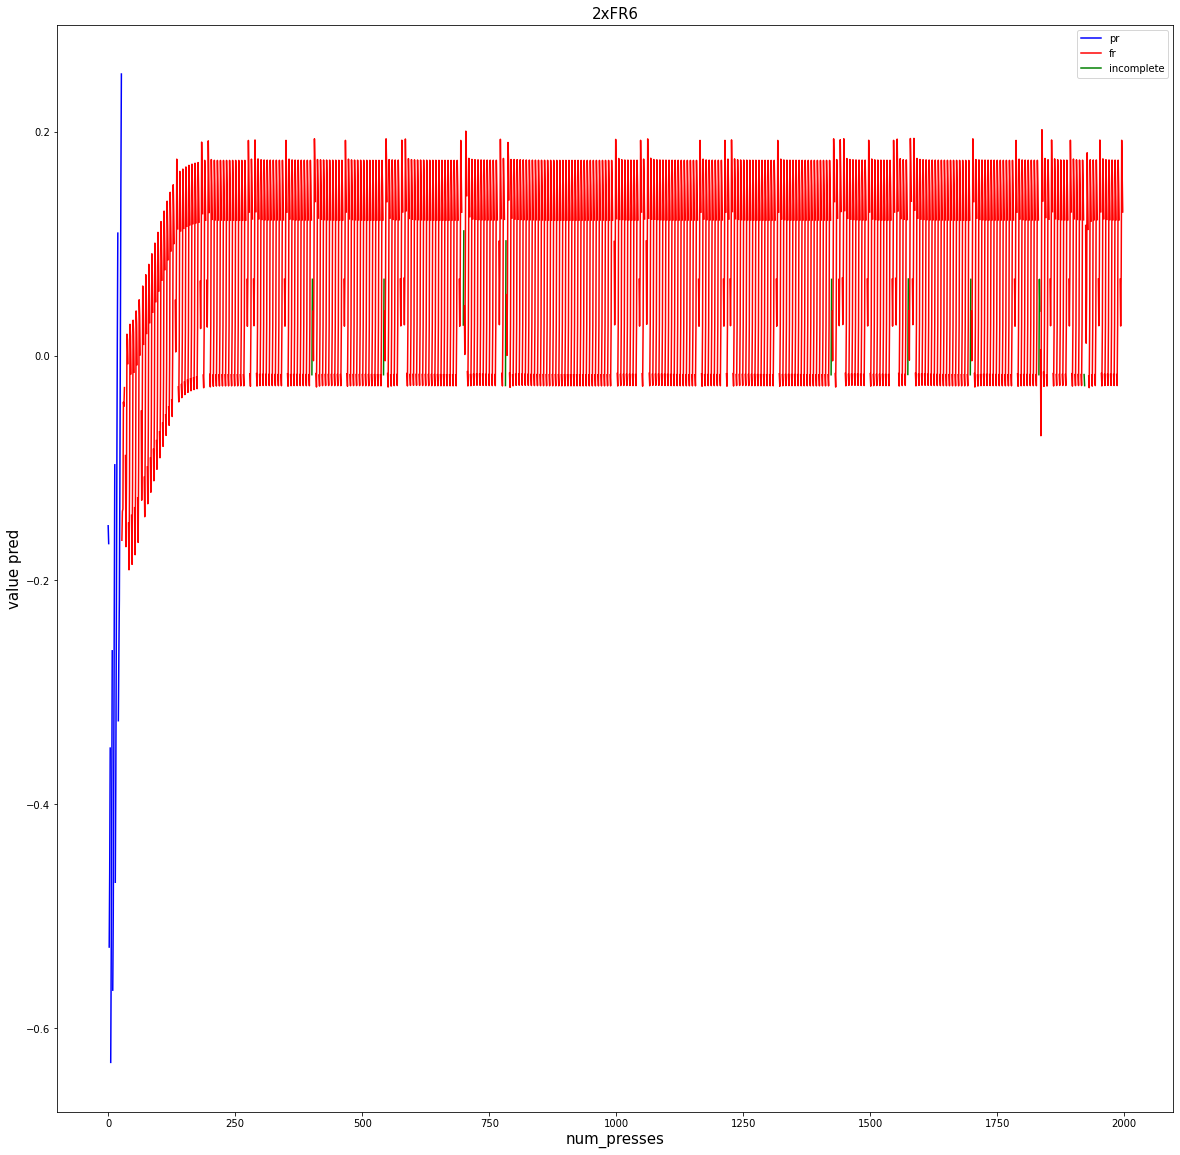

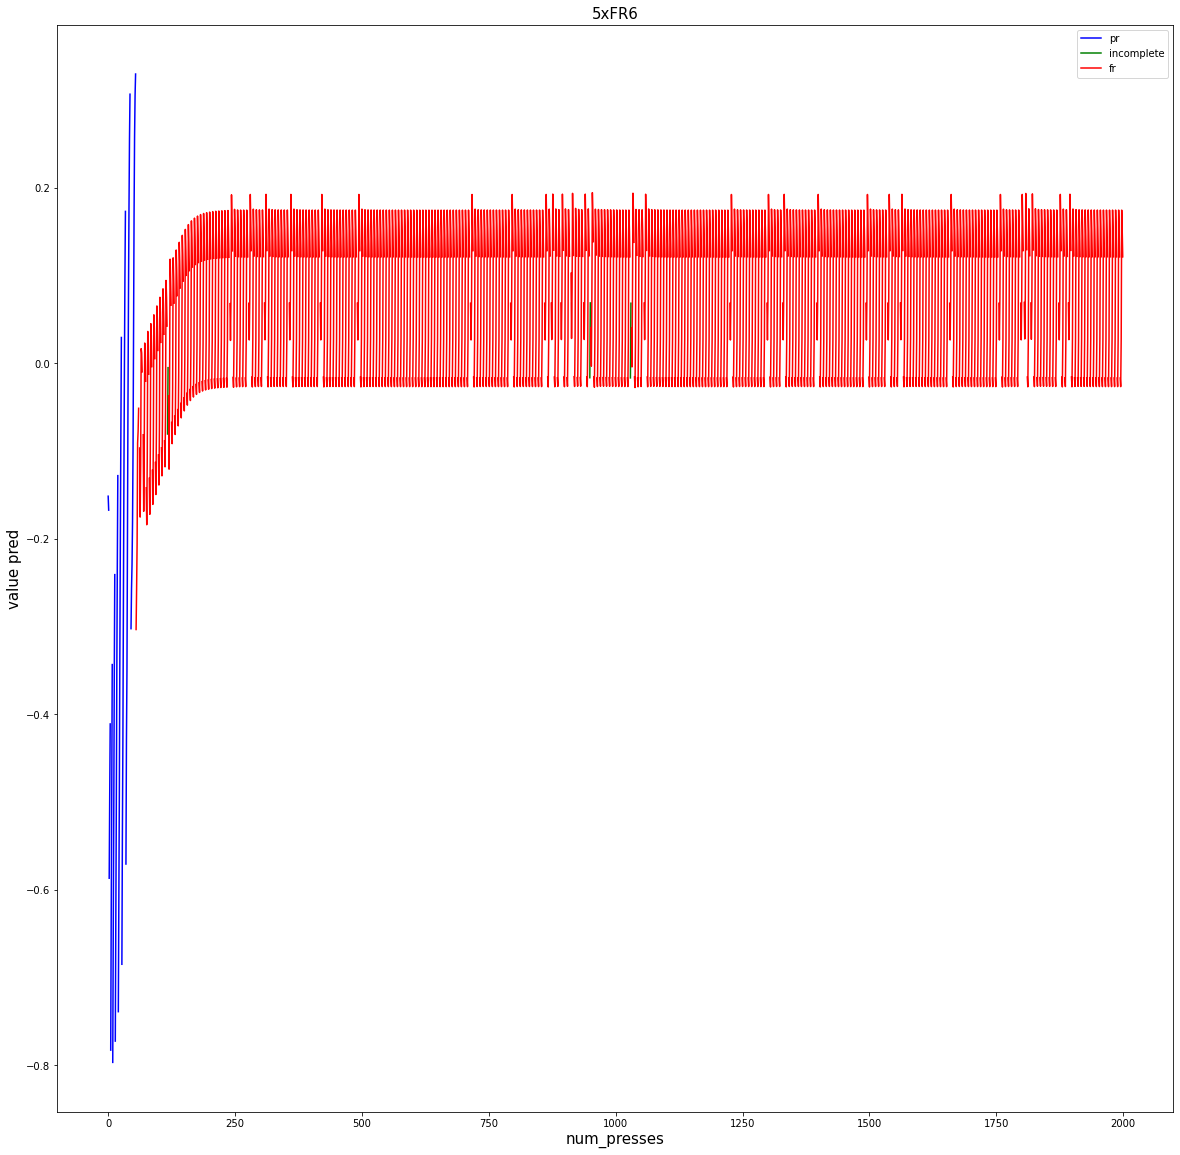

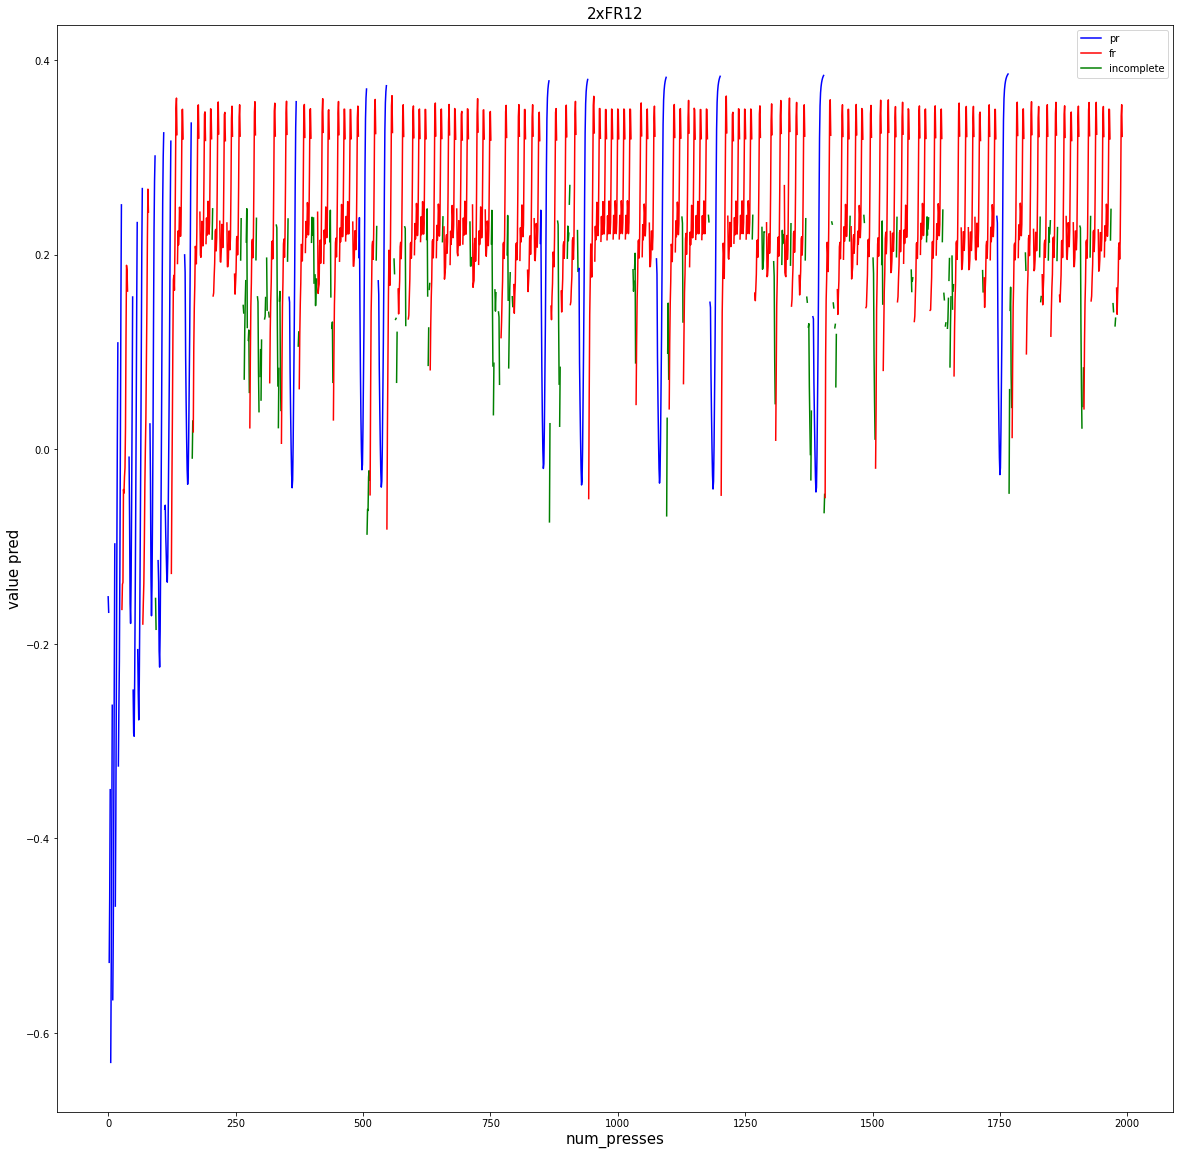

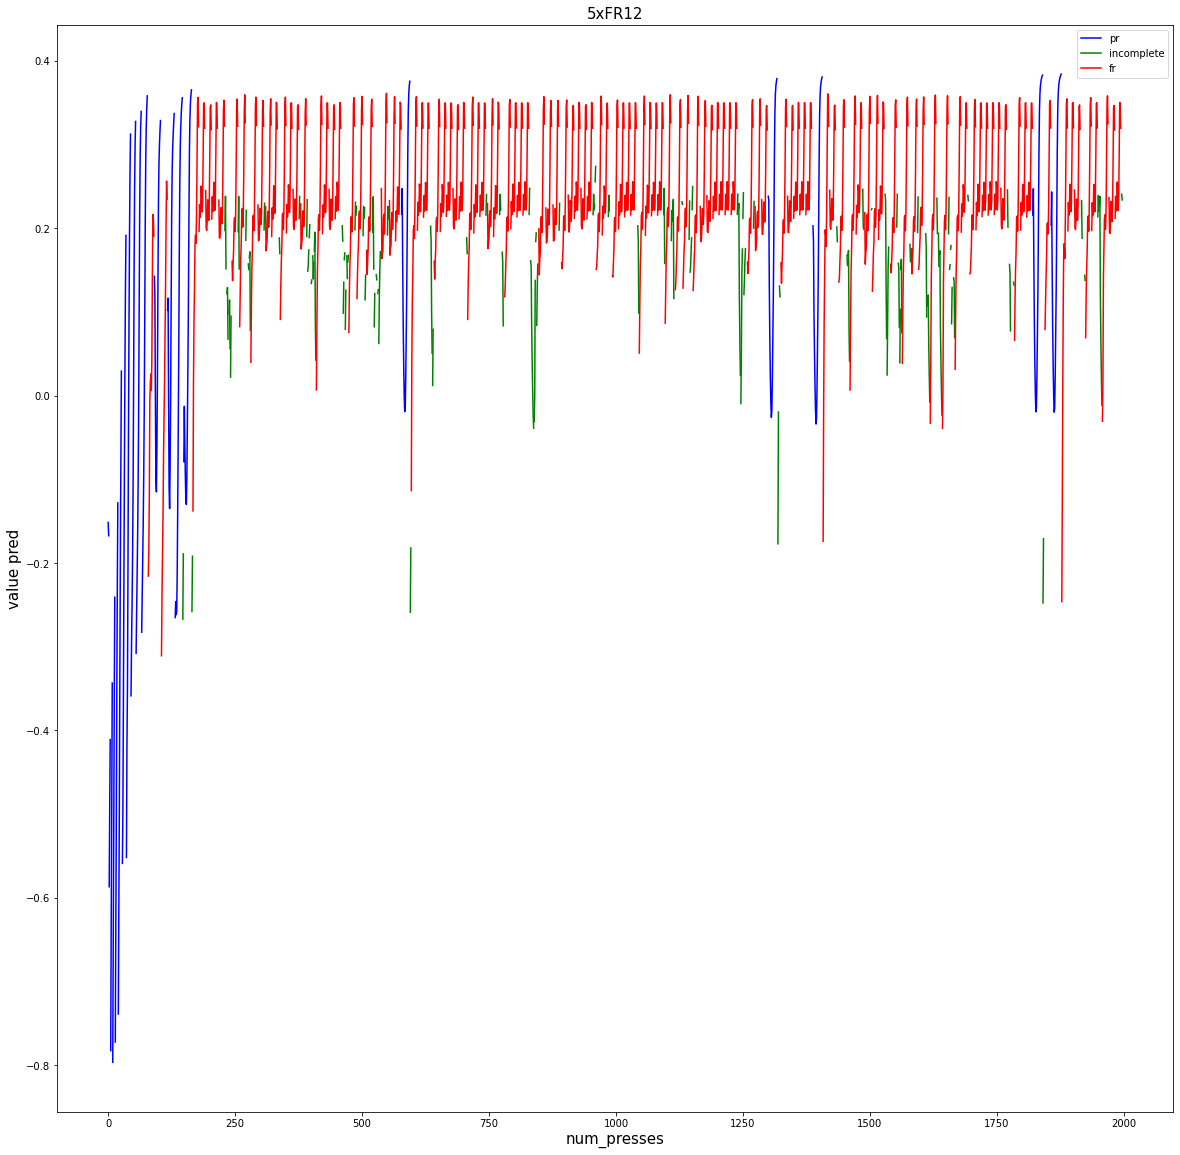

In [50]:
for (FR_limit, PR_reward), sessions in d.items(): # for each parameter setting
    for (actions, rewards, value_preds, activ_hist) in sessions: # for each session under a setting
        trials, trial_tags, trial_values = count_trials(actions, rewards, value_preds)
        exploration_values = ([trial_values[i] for i in range(len(trial_tags)) if trial_tags[i] == 2])
        exploitation_values = ([trial_values[i] for i in range(len(trial_tags)) if trial_tags[i] != 2])
#         plt.plot(np.concatenate(exploration_values), color = 'blue')
#         plt.plot(np.concatenate(exploitation_values), color = 'red')
    
    
        plt.figure(figsize = (20, 20))
        start = 0
        color = ['blue', 'red', 'green']
        label = ['pr', 'fr', 'incomplete']
        for i in range(len(trial_tags)):
            trial_value = trial_values[i]
            end = start + len(trial_value)
            plt.plot(np.arange(start, end), trial_value, color=color[trial_tags[i]], label=label[trial_tags[i]])
            label[trial_tags[i]] = "_nolegend_"
            start = end
        plt.xlabel('num_presses', fontsize=15)
        plt.ylabel('value pred', fontsize=15)
        plt.title('%dxFR%d'%(PR_reward, FR_limit), fontsize=15)
        plt.legend()
        break
